In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import json
import glob
import keras
from datetime import timedelta
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import json
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


- Clean notebook to be only new 
- Be able to merge train features and train targets
- same with test
- be able to then split and run program
- test for overfit
- create additional features (business/extra features from swing/ extra features from bugs)
- run reviews for NLP

In [2]:
list_of_file_names = glob.glob("./zip_2/*.csv")

In [3]:
read_data_list_2 = []
fail_list = []
for i, data in enumerate(list_of_file_names):
    try:
        data = pd.read_csv(data)
        #data = unicode(data, errors='replace')
        read_data_list_2.append(data)
    except UnicodeDecodeError:
        fail_list.append(i)
#read_data_list
#fail_list
list_of_file_names_org = list_of_file_names

In [4]:
fail_list

[3]

In [5]:
for x in fail_list:
    del list_of_file_names[x]

In [6]:
list_of_file_names[23]

'./zip_2/Zip_MedianListingPricePerSqft_AllHomes.csv'

In [7]:
# build loop for data we can work with. Only dates and zip
def build_useful_df(data_list):
    useful_df = []
    for dataset in range(len(data_list)):
        data = read_data_list_2[dataset].copy()
        region_name = data['RegionName']
        region_name = region_name.astype(str)
        new_df = data.select_dtypes(include=['float64'])
        new_df.insert(loc=0, column='RegionName', value=region_name) 
        new_df = new_df.sort_values('RegionName',ascending=False)
        new_df = new_df.set_index('RegionName')
        useful_df.append(new_df)
    return useful_df

In [403]:
useful_df = build_useful_df(read_data_list_2)


In [275]:
#--------make sure to move business up here
sixteen_list = []
for i, file in enumerate(useful_df):
    slce = file[file.index.isin(business_features.index)]
    if len(slce) >= 333:
        sixteen_list.append(i)

In [200]:
#sixteen_list_t

In [404]:
sixteen_list = []
for i, file in enumerate(useful_df):
    if len(file) >= 10000:
        sixteen_list.append(i)

In [405]:
len(sixteen_list)

30

In [406]:
good_columns = []
for i, file in enumerate(useful_df):
    columns = file.columns
    if '2017-01' in columns:
        good_columns.append(i)

In [407]:
sixteen_good = []
for num in sixteen_list:
    if num in good_columns:
        sixteen_good.append(num)

In [408]:
len(sixteen_good)

12

In [409]:
target_data = useful_df[23]

In [410]:
final_data_list = []
for i, data in enumerate(useful_df):
    if i in sixteen_good:
        final_data_list.append(data)

In [411]:
len(final_data_list)

12

In [303]:
# Docs that don't need feature engineering. They are already aggregates
pure_features = [0, 71, 75, 77, 79, 81]
useful_df[0].head()

,PctPriceCut,DaysOnMarket,BuyerSellerIndex,BuyerSellerIndexMetro
RegionName,,,,
99654,11.142857,82.0,9.230769,7.260083
99645,7.589286,74.0,0.769231,7.260083
99577,8.108108,79.5,4.615385,7.260083
99567,9.836066,76.0,2.307692,7.260083
99518,14.925373,85.0,10.000000,7.260083


In [613]:
def make_features(df, past_time_string, now_string):
    #df.dropna(inplace=True)
    features = pd.DataFrame()
    #features['RegionName'] = df['RegionName']
    mean = df.loc[:, past_time_string : now_string].mean(axis=1)
    features['mean'] = mean
    std = df.loc[:, past_time_string : now_string].std(axis=1)
    features['std'] = std
    mn = df.loc[:, past_time_string : now_string].min(axis=1)
    features['min'] = mn
    mx = df.loc[:, past_time_string : now_string].max(axis=1)
    features['max'] = mx
    features['swing'] = mx - mn
    change = df[now_string] - df[past_time_string]
    features['change'] = change
    mean_swing = features['swing'].mean()
    features['swing_pos'] = np.where(features['swing']>mean_swing, 1, 0)
    big_swing = features['swing'].std() + mean_swing
    features['swing_big'] = np.where(features['swing']>big_swing, 1, 0)
    features['swing_neg'] = np.where(features['swing']<mean_swing, 1, 0)
    swing_big_loss = mean_swing - features['swing'].std() 
    features['swing_loss_big'] = np.where(features['swing']<swing_big_loss, 1, 0)
    #features.dropna(inplace=True)
    
    #features = features.set_index(df.index)
    #print(features.iloc[1, :])
    return features
    
# List of data frames only on one now_time
def make_modeling_data(df_list, df_for_target, now_string):
    df_one = pd.DataFrame()
    target = pd.DataFrame()
    now_time = pd.to_datetime(now_string)
    now_value = df_for_target[now_string]
    future_time = now_time + timedelta(days=6*31)
    future_time_string= future_time.strftime("%Y-%m")
    future_value = df_for_target[future_time_string]
    target['target'] = future_value/now_value
    
    
    past_time = now_time - timedelta(days=6*31)
    past_time_string= past_time.strftime("%Y-%m")
    df_to_use_for_features_org= df_list[0].loc[:, :now_string]
    features_org = make_features(df_to_use_for_features_org, past_time_string, now_string)
    df_one = pd.merge(df_one, features_org, left_index=True, right_index=True, how = 'right')
    for i, df in enumerate(df_list[1:]):
        ind = str(i)
        columns = df.columns
        if '2011-01' in columns and '2012-01' in columns and '2013-01' in columns and '2014-01' in columns and '2015-01' in columns and '2016-01' in columns and '2017-01' in columns:
            df_to_use_for_features= df.loc[:, :now_string]
            features = make_features(df_to_use_for_features, past_time_string, now_string)
            df_one = pd.merge(df_one, features, right_index=True, left_index=True, how='inner')
    target = target.loc[df_one.index]    
    #now_time = pd.to_datetime(now_string)
    #now_value = df_for_target[now_string]
    #future_time = now_time + timedelta(days=6*31)
    #future_time_string= future_time.strftime("%Y-%m")
    #future_value = df_for_target[future_time_string]
            #target = future_value/now_value

    
    return df_one, target




test_features, test_targets = make_modeling_data(final_data_list, target_data, "2017-06")
train_features, train_targets = make_modeling_data(final_data_list, target_data, "2017-01")
#extra_train_features_1, extra_train_targets_1 = make_modeling_data(final_data_list, target_data, '2016-06')
#train_features = train_features.append(extra_train_features_1)
#train_targets = train_targets.append(extra_train_targets_1)






#df = useful_df[num]
#columns = df.columns
#"2012", "2012", "2013",
date_counter = 0
for year in ["2012", "2013", "2014", "2015", "2016"]:
    for month in ["01","02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]:
            new_time = year+"-"+month
            date_counter += 1
            #if '2014-01' in columns and '2015-01' in columns and '2016-01' in columns and '2017-01' in columns:
                    #extra_train_features, extra_train_targets = make_modeling_data(df, new_time)
                    #train_features = train_features.append(extra_train_features)
                    #train_targets = train_targets.append(extra_train_targets)
            extra_train_features, extra_train_targets = make_modeling_data(final_data_list, target_data, new_time)
            #extra_train_features.dropna(inplace=True)
            train_features = train_features.append(extra_train_features)
            train_targets = train_targets.append(extra_train_targets)

In [614]:
train_targets.shape

(336171, 1)

In [615]:
train_features.shape

(336171, 120)

In [616]:
train_targets.index.nunique()

5511

In [170]:
test_features.to_csv('test_features_to_merge_final.csv')

In [23]:
train_targets.head()

,target
RegionName,
99362,1.047544
99353,1.122185
99352,1.061993
99338,1.073945
99337,1.084956


#### Have not worked on w2v today; focused on business

In [617]:
w2v_features = pd.read_csv('real_business_w2v_features_3_6')

In [618]:
w2v_features['postal_code'] = w2v_features['postal_code'].astype(str)

In [619]:
w2v_features.shape

(959, 512)

In [620]:
w2v_features.index = w2v_features['postal_code']

In [621]:
w2v_features = w2v_features.iloc[:, 1:]

In [622]:
w2v_features.head()

,is_open,latitude,longitude,review_count,stars,average_review_count,business_count,zip_review_count,average_review_max,average_review_min,...,490,491,492,493,494,495,496,497,498,499
postal_code,,,,,,,,,,,,,,,,,,,,,
2224,1.0,41.499208,-81.536689,7.000000,2.500000,7.000000,1.0,7.0,7.0,7.0,...,-0.007905,-0.050745,0.019509,0.089886,-0.067859,-0.057686,-0.073559,0.004500,-0.062522,0.054272
5440,1.0,44.964078,-73.285549,4.000000,4.250000,4.000000,2.0,8.0,5.0,3.0,...,0.024744,0.024881,0.039596,0.043280,-0.032233,-0.017144,0.060047,-0.002217,0.063483,-0.041164
5452,1.0,40.780821,-74.150722,49.000000,4.000000,49.000000,1.0,49.0,49.0,49.0,...,-0.032312,-0.024693,-0.019165,0.015924,-0.044335,-0.020998,0.041530,-0.048317,0.086379,-0.008370
6618,1.0,51.083200,11.858200,8.000000,3.500000,8.000000,1.0,8.0,8.0,8.0,...,-0.014649,0.000344,0.033006,-0.015937,0.011044,0.094979,0.085854,-0.037768,-0.038649,0.033392
6632,1.0,51.213256,11.763245,5.888889,4.222222,5.888889,9.0,53.0,8.0,3.0,...,-0.013431,0.007048,0.017738,-0.013003,0.016217,0.083113,0.092610,-0.032904,-0.048000,0.023717


#### Here is where business is imported

In [623]:
# Up to date business features where all rows are a singular zipcode
business_features = pd.read_csv('real_business_features_3_4')

In [624]:
len(business_features)

959

In [625]:
business_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 959 entries, 0 to 958
Data columns (total 11 columns):
postal_code             959 non-null int64
is_open                 959 non-null float64
latitude                959 non-null float64
longitude               959 non-null float64
review_count            959 non-null float64
stars                   959 non-null float64
average_review_count    959 non-null float64
business_count          959 non-null float64
zip_review_count        959 non-null float64
average_review_max      959 non-null float64
average_review_min      959 non-null float64
dtypes: float64(10), int64(1)
memory usage: 82.5 KB


In [626]:
business_features.shape

(959, 11)

In [627]:
business_features['postal_code'] = business_features['postal_code'].astype(str)

In [496]:
business_features['postal_code'].nunique()

959

In [649]:
business_features = business_features.set_index('postal_code')

In [498]:
business_features.head()

,is_open,latitude,longitude,review_count,stars,average_review_count,business_count,zip_review_count,average_review_max,average_review_min
postal_code,,,,,,,,,,
2224,1.0,41.499208,-81.536689,7.000000,2.500000,7.000000,1.0,7.0,7.0,7.0
5440,1.0,44.964078,-73.285549,4.000000,4.250000,4.000000,2.0,8.0,5.0,3.0
5452,1.0,40.780821,-74.150722,49.000000,4.000000,49.000000,1.0,49.0,49.0,49.0
6618,1.0,51.083200,11.858200,8.000000,3.500000,8.000000,1.0,8.0,8.0,8.0
6632,1.0,51.213256,11.763245,5.888889,4.222222,5.888889,9.0,53.0,8.0,3.0


In [504]:
test_features.shape

(5511, 120)

In [430]:
train_features.shape

(336171, 120)

In [628]:
train_features = train_features.reset_index()

In [629]:
test_features = test_features.reset_index()

In [630]:
train_features['RegionName'].nunique()

5511

In [533]:
len(test_features)

5511

In [631]:
train_targets = train_targets.reset_index()

In [632]:
test_targets = test_targets.reset_index()

In [633]:
# Merging on index for train features and targets so it doesn't multiply 
train_merge = pd.merge(train_features, train_targets, right_index=True, left_index=True, how='inner')

In [634]:
test_merge = pd.merge(test_features, test_targets, right_index=True, left_index=True, how='inner')

In [635]:
len(train_merge)

336171

In [636]:
test_merge.head()

,RegionName_x,mean_x,std_x,min_x,max_x,swing_x,change_x,swing_pos_x,swing_big_x,swing_neg_x,...,min_y,max_y,swing_y,change_y,swing_pos_y,swing_big_y,swing_neg_y,swing_loss_big_y,RegionName_y,target
0,99362,9.899305,2.694838,7.225547,15.562721,8.337174,-8.337174,0,0,1,...,0.874,0.894,0.020,0.018,0,0,1,0,99362,1.000168
1,99353,12.713502,4.201132,8.701869,20.788350,12.086481,6.728607,1,1,0,...,0.874,0.886,0.012,-0.010,0,0,1,0,99353,1.137133
2,99352,13.114296,2.222078,10.907130,17.667674,6.760545,2.172499,0,0,1,...,0.900,0.908,0.008,-0.004,0,0,1,0,99352,1.011334
3,99338,10.337470,2.859324,6.462035,15.113417,8.651382,-1.678754,1,0,0,...,0.884,0.896,0.012,0.008,0,0,1,0,99338,1.014762
4,99337,12.309892,3.922309,7.724349,18.444138,10.719789,-6.511823,1,0,0,...,0.878,0.890,0.012,0.012,0,0,1,0,99337,1.062254


In [637]:
train_merge = train_merge.set_index('RegionName_x')

In [638]:
test_merge = test_merge.set_index('RegionName_x')

In [639]:
test_merge.index.nunique()

5511

In [640]:
business_features.index.nunique()

959

In [348]:
train_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 336171 entries, 99362 to 1001
Columns: 124 entries, index_x to target
dtypes: float64(73), int64(50), object(1)
memory usage: 320.6+ MB


In [648]:
business_features.shape

(959, 11)

In [350]:
business_features.head()

,is_open,latitude,longitude,review_count,stars,average_review_count,business_count,zip_review_count,average_review_max,average_review_min
postal_code,,,,,,,,,,
2224,1.0,41.499208,-81.536689,7.000000,2.500000,7.000000,1.0,7.0,7.0,7.0
5440,1.0,44.964078,-73.285549,4.000000,4.250000,4.000000,2.0,8.0,5.0,3.0
5452,1.0,40.780821,-74.150722,49.000000,4.000000,49.000000,1.0,49.0,49.0,49.0
6618,1.0,51.083200,11.858200,8.000000,3.500000,8.000000,1.0,8.0,8.0,8.0
6632,1.0,51.213256,11.763245,5.888889,4.222222,5.888889,9.0,53.0,8.0,3.0


In [647]:
test_merge.head()

,mean_x,std_x,min_x,max_x,swing_x,change_x,swing_pos_x,swing_big_x,swing_neg_x,swing_loss_big_x,...,min_y,max_y,swing_y,change_y,swing_pos_y,swing_big_y,swing_neg_y,swing_loss_big_y,RegionName_y,target
RegionName_x,,,,,,,,,,,,,,,,,,,,,
99362,9.899305,2.694838,7.225547,15.562721,8.337174,-8.337174,0,0,1,0,...,0.874,0.894,0.020,0.018,0,0,1,0,99362,1.000168
99353,12.713502,4.201132,8.701869,20.788350,12.086481,6.728607,1,1,0,0,...,0.874,0.886,0.012,-0.010,0,0,1,0,99353,1.137133
99352,13.114296,2.222078,10.907130,17.667674,6.760545,2.172499,0,0,1,0,...,0.900,0.908,0.008,-0.004,0,0,1,0,99352,1.011334
99338,10.337470,2.859324,6.462035,15.113417,8.651382,-1.678754,1,0,0,0,...,0.884,0.896,0.012,0.008,0,0,1,0,99338,1.014762
99337,12.309892,3.922309,7.724349,18.444138,10.719789,-6.511823,1,0,0,0,...,0.878,0.890,0.012,0.012,0,0,1,0,99337,1.062254


In [351]:
train_merge['RegionName_y'].nunique()

5511

In [650]:
business_train_merge = pd.merge(train_merge, business_features, right_index=True, left_index=True, how='inner')

In [651]:
business_test_merge = pd.merge(test_merge, business_features, right_index=True, left_index=True, how='inner')

In [643]:
w2v_train_merge = pd.merge(train_merge, w2v_features, right_index=True, left_index=True, how='inner')

In [644]:
w2v_test_merge = pd.merge(test_merge, w2v_features, right_index=True, left_index=True, how='inner')

In [652]:
new_zillow_test_merge = pd.merge(test_merge, business_features, right_index=True, left_index=True, how='inner')

In [653]:
new_zillow_test_merge.shape

(333, 132)

In [654]:
nztmc = new_zillow_test_merge.columns
test_merge = new_zillow_test_merge.iloc[:, :-10]

In [655]:
len(train_merge.columns)

122

In [656]:
len(test_merge.columns)

122

In [451]:
# This should have all instances of the train and test. 
business_train_merge.shape

(20313, 132)

In [452]:
w2v_train_merge.shape

(20313, 633)

In [657]:
train_merge = train_merge.drop('RegionName_y', 1)

In [658]:
test_merge = test_merge.drop('RegionName_y', 1)

### Most up to date Business attempt
- Why is y glitching with NaN?
- Update I have not removed any NaN's yet

In [363]:
train_merge.columns

Index(['index_x', 'mean_x', 'std_x', 'min_x', 'max_x', 'swing_x', 'change_x',
       'swing_pos_x', 'swing_big_x', 'swing_neg_x',
       ...
       'min_y', 'max_y', 'swing_y', 'change_y', 'swing_pos_y', 'swing_big_y',
       'swing_neg_y', 'swing_loss_big_y', 'index_y', 'target'],
      dtype='object', length=123)

In [659]:
train_merge.dropna(inplace=True)

In [660]:
test_merge.dropna(inplace=True)

In [661]:
train_merge.index.nunique()

5337

In [662]:
test_merge.index.nunique()

331

In [663]:
business_train_merge.dropna(inplace=True)

In [664]:
business_test_merge.dropna(inplace=True)

In [665]:
w2v_train_merge.dropna(inplace=True)

In [666]:
w2v_test_merge.dropna(inplace=True)

In [463]:
w2v_train_merge.index.nunique()

326

In [464]:
w2v_test_merge.index.nunique()

326

In [465]:
# 169 zipcodes in common after dropna. Had about double that before
business_test_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 326 entries, 95966 to 15017
Columns: 132 entries, mean_x to average_review_min
dtypes: float64(83), int64(48), object(1)
memory usage: 338.7+ KB


In [466]:
col = w2v_test_merge.columns

In [467]:
col[120:130]

Index(['RegionName_y', 'target', 'is_open', 'latitude', 'longitude',
       'review_count', 'stars', 'average_review_count', 'business_count',
       'zip_review_count'],
      dtype='object')

In [667]:
X_train = train_merge.iloc[:, :-1].values
y_train = train_merge.iloc[:, -1].values
X_test = test_merge.iloc[:, :-1].values
y_test = test_merge.iloc[:, -1].values

In [668]:
w2v_train_merge = w2v_train_merge.drop('RegionName_y', 1)
w2v_test_merge = w2v_test_merge.drop('RegionName_y', 1)
y_train_w2v = w2v_train_merge.loc[:, 'target'].values
y_test_w2v = w2v_test_merge.loc[:, 'target'].values
w2v_train = pd.DataFrame()
w2v_train_features = w2v_train_merge.drop('target', 1).values
X_train_w2v = pd.DataFrame()
X_train_w2v = w2v_train_features
X_test_w2v_features = pd.DataFrame()
X_test_w2v_features = w2v_test_merge.drop('target', 1).values
X_test_w2v = pd.DataFrame()
X_test_w2v = X_test_w2v_features

In [669]:
# Setting up train and test
business_train_merge = business_train_merge.drop('RegionName_y', 1)
business_test_merge = business_test_merge.drop('RegionName_y', 1)
y_train_business = business_train_merge.loc[:, 'target'].values
y_test_business = business_test_merge.loc[:, 'target'].values
business_train = pd.DataFrame()
business_train_features = business_train_merge.drop('target', 1).values
X_train_business = pd.DataFrame()
X_train_business = business_train_features
X_test_business_features = pd.DataFrame()
X_test_business_features = business_test_merge.drop('target', 1).values
X_test_business = pd.DataFrame()
X_test_business = X_test_business_features

In [471]:
X_test_business.shape

(326, 130)

In [472]:
X_train_w2v.shape

(12650, 631)

In [473]:
X_test_w2v.shape

(326, 631)

In [474]:
X_test.columns

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [475]:
def norm_per_column(X):
    new_array = []
    shape = X.shape
    columns = shape[1]
    for num in range(columns):
        mx = X[:, num].max()
        if mx == 0:
            new_array.append(X[:, num])
        else:
            X[:, num] = X[:, num] / mx
            new_array.append(X[:, num])
    new_array = np.array(new_array)
    new_array = np.transpose(new_array)
    return new_array

In [670]:
X_train = norm_per_column(X_train)
X_test = norm_per_column(X_test)

In [671]:
X_train_business = norm_per_column(X_train_business)
X_test_business = norm_per_column(X_test_business)

In [672]:
X_train_w2v = norm_per_column(X_train_w2v)
X_test_w2v = norm_per_column(X_test_w2v)

In [85]:
y_test.var()

0.0024781259706054431

In [86]:
print(y_test.mean())
print(y_test.min())
print(y_test.max())

1.02503628443
0.769951258197
1.33987220683


In [87]:
def create_y_class(y_list):
    y_df = pd.DataFrame()
    y_1 = []
    y_2 = []
    y_3 = []
    y_4 = []
    y_5 = []
    y_6 = []
    y_7 = []
    for y in y_list:
        if y <= .83:
            y_1.append(1)
        else:
            y_1.append(0)
        if y > .83 and y <= .90:
            y_2.append(1)
        else:
            y_2.append(0)
        if y > .90 and y <= .97:
            y_3.append(1)
        else:
            y_3.append(0)
        if y > .97 and y <= 1.05:
            y_4.append(1)
        else:
            y_4.append(0)
        if y > 1.05 and y <= 1.12:
            y_5.append(1)
        else:
            y_5.append(0)
        if y > 1.12 and y <= 1.19:
            y_6.append(1)
        else:
            y_6.append(0)
        if y > 1.19:
            y_7.append(1)
        else:
            y_7.append(0)
    y_df['1'] = y_1
    y_df['2'] = y_2
    y_df['3'] = y_3
    y_df['4'] = y_4
    y_df['5'] = y_5
    y_df['6'] = y_6
    y_df['7'] = y_7
    return y_df

In [673]:
y_cat_train = create_y_class(y_train)

In [674]:
y_cat_test = create_y_class(y_test)

In [675]:
y_cat_train_w2v = create_y_class(y_train_w2v)

In [676]:
y_cat_test_w2v = create_y_class(y_test_w2v)

In [677]:
y_cat_train_business = create_y_class(y_train_business)

In [678]:
y_cat_test_business = create_y_class(y_test_business)

In [679]:
y_cat_train.head()

,1,2,3,4,5,6,7
0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0


In [680]:
y_test_business.var()

0.0028560998107322942

In [62]:
# Hold overfit model for now
model = Sequential()
model.add(Dense(3000, input_shape=(110,), activation='relu'))
model.add(Dense(2000, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer='Adam',
              loss='mean_squared_error')

In [574]:
model = Sequential()
model.add(Dense(300, input_shape=(120,), activation='relu'))
model.add(Dropout(.05))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(1, activation='linear'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.00001)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='mean_squared_error')

In [575]:
model.fit(x=X_train, y=y_train, 
          batch_size=20000, 
          epochs=100, 
          verbose=1, 
          validation_data=(X_test, y_test),
          callbacks=None)

Train on 218212 samples, validate on 326 samples
Epoch 1/100
218212/218212 [==============================] - 6s 29us/step - loss: 1.2121 - val_loss: 1.1834
Epoch 2/100
218212/218212 [==============================] - 4s 19us/step - loss: 1.1496 - val_loss: 1.1145
Epoch 3/100
218212/218212 [==============================] - 4s 19us/step - loss: 1.0979 - val_loss: 1.0516
Epoch 4/100
218212/218212 [==============================] - 4s 19us/step - loss: 1.0499 - val_loss: 0.9916
Epoch 5/100
218212/218212 [==============================] - 4s 20us/step - loss: 1.0020 - val_loss: 0.9337
Epoch 6/100
218212/218212 [==============================] - 4s 20us/step - loss: 0.9553 - val_loss: 0.8777
Epoch 7/100
218212/218212 [==============================] - 4s 20us/step - loss: 0.9091 - val_loss: 0.8235
Epoch 8/100
218212/218212 [==============================] - 4s 19us/step - loss: 0.8628 - val_loss: 0.7709
Epoch 9/100
218212/218212 [==============================] - 4s 19us/step - loss: 0.817

Epoch 76/100
218212/218212 [==============================] - 4s 20us/step - loss: 0.0198 - val_loss: 0.0109
Epoch 77/100
218212/218212 [==============================] - 4s 20us/step - loss: 0.0196 - val_loss: 0.0104
Epoch 78/100
218212/218212 [==============================] - 4s 19us/step - loss: 0.0195 - val_loss: 0.0109
Epoch 79/100
218212/218212 [==============================] - 4s 19us/step - loss: 0.0193 - val_loss: 0.0106
Epoch 80/100
218212/218212 [==============================] - 4s 20us/step - loss: 0.0191 - val_loss: 0.0104
Epoch 81/100
218212/218212 [==============================] - 4s 20us/step - loss: 0.0189 - val_loss: 0.0104
Epoch 82/100
218212/218212 [==============================] - 4s 19us/step - loss: 0.0189 - val_loss: 0.0106
Epoch 83/100
218212/218212 [==============================] - 5s 22us/step - loss: 0.0188 - val_loss: 0.0101
Epoch 84/100
218212/218212 [==============================] - 4s 20us/step - loss: 0.0186 - val_loss: 0.0103
Epoch 85/100
218212

In [ ]:
#loss = .00001441 (overfit) = .0038

#std = .072

In [576]:
model = Sequential()
model.add(Dense(300, input_shape=(130,), activation='relu'))
model.add(Dropout(.05))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(1, activation='linear'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.00001)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='mean_squared_error')

In [577]:
model.fit(x=X_train_business, y=y_train_business, 
          batch_size=2000, 
          epochs=2000, 
          verbose=1, 
          validation_data=(X_test_business, y_test_business),
          callbacks=None)

Train on 12650 samples, validate on 326 samples
Epoch 1/2000
12650/12650 [==============================] - 2s 130us/step - loss: 0.9601 - val_loss: 0.8660
Epoch 2/2000
12650/12650 [==============================] - 0s 24us/step - loss: 0.8416 - val_loss: 0.7615
Epoch 3/2000
12650/12650 [==============================] - 0s 24us/step - loss: 0.7543 - val_loss: 0.6759
Epoch 4/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.6843 - val_loss: 0.6005
Epoch 5/2000
12650/12650 [==============================] - 0s 25us/step - loss: 0.6224 - val_loss: 0.5323
Epoch 6/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.5687 - val_loss: 0.4695
Epoch 7/2000
12650/12650 [==============================] - 0s 23us/step - loss: 0.5126 - val_loss: 0.4116
Epoch 8/2000
12650/12650 [==============================] - 0s 24us/step - loss: 0.4588 - val_loss: 0.3585
Epoch 9/2000
12650/12650 [==============================] - 0s 22us/step - loss: 0.4086 - val_l

12650/12650 [==============================] - 0s 21us/step - loss: 0.0380 - val_loss: 0.0100
Epoch 77/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0378 - val_loss: 0.0099
Epoch 78/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0372 - val_loss: 0.0100
Epoch 79/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0369 - val_loss: 0.0100
Epoch 80/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0358 - val_loss: 0.0098
Epoch 81/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0347 - val_loss: 0.0098
Epoch 82/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0358 - val_loss: 0.0098
Epoch 83/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0366 - val_loss: 0.0097
Epoch 84/2000
12650/12650 [==============================] - 0s 20us/step - loss: 0.0350 - val_loss: 0.0096
Epoch 85/2000
12650/12650 [===============

12650/12650 [==============================] - 0s 26us/step - loss: 0.0237 - val_loss: 0.0067
Epoch 152/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.0232 - val_loss: 0.0067
Epoch 153/2000
12650/12650 [==============================] - 0s 27us/step - loss: 0.0228 - val_loss: 0.0067
Epoch 154/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.0231 - val_loss: 0.0068
Epoch 155/2000
12650/12650 [==============================] - 0s 27us/step - loss: 0.0234 - val_loss: 0.0068
Epoch 156/2000
12650/12650 [==============================] - 0s 25us/step - loss: 0.0223 - val_loss: 0.0066
Epoch 157/2000
12650/12650 [==============================] - 0s 27us/step - loss: 0.0222 - val_loss: 0.0067
Epoch 158/2000
12650/12650 [==============================] - 0s 23us/step - loss: 0.0228 - val_loss: 0.0066
Epoch 159/2000
12650/12650 [==============================] - 0s 24us/step - loss: 0.0228 - val_loss: 0.0066
Epoch 160/2000
12650/12650 [======

12650/12650 [==============================] - 0s 25us/step - loss: 0.0178 - val_loss: 0.0053
Epoch 227/2000
12650/12650 [==============================] - 0s 25us/step - loss: 0.0179 - val_loss: 0.0054
Epoch 228/2000
12650/12650 [==============================] - 0s 27us/step - loss: 0.0180 - val_loss: 0.0050
Epoch 229/2000
12650/12650 [==============================] - 0s 23us/step - loss: 0.0180 - val_loss: 0.0050
Epoch 230/2000
12650/12650 [==============================] - 0s 22us/step - loss: 0.0179 - val_loss: 0.0049
Epoch 231/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0183 - val_loss: 0.0051
Epoch 232/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0178 - val_loss: 0.0051
Epoch 233/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0174 - val_loss: 0.0051
Epoch 234/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0177 - val_loss: 0.0050
Epoch 235/2000
12650/12650 [======

12650/12650 [==============================] - 0s 26us/step - loss: 0.0146 - val_loss: 0.0043
Epoch 302/2000
12650/12650 [==============================] - 0s 25us/step - loss: 0.0153 - val_loss: 0.0044
Epoch 303/2000
12650/12650 [==============================] - 0s 24us/step - loss: 0.0145 - val_loss: 0.0042
Epoch 304/2000
12650/12650 [==============================] - 0s 25us/step - loss: 0.0155 - val_loss: 0.0044
Epoch 305/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.0154 - val_loss: 0.0043
Epoch 306/2000
12650/12650 [==============================] - 0s 27us/step - loss: 0.0151 - val_loss: 0.0042
Epoch 307/2000
12650/12650 [==============================] - 0s 24us/step - loss: 0.0149 - val_loss: 0.0044
Epoch 308/2000
12650/12650 [==============================] - 0s 27us/step - loss: 0.0152 - val_loss: 0.0043
Epoch 309/2000
12650/12650 [==============================] - 0s 27us/step - loss: 0.0152 - val_loss: 0.0041
Epoch 310/2000
12650/12650 [======

12650/12650 [==============================] - 0s 23us/step - loss: 0.0134 - val_loss: 0.0039
Epoch 377/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0138 - val_loss: 0.0038
Epoch 378/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0134 - val_loss: 0.0038
Epoch 379/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0135 - val_loss: 0.0039
Epoch 380/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0135 - val_loss: 0.0038
Epoch 381/2000
12650/12650 [==============================] - 0s 22us/step - loss: 0.0138 - val_loss: 0.0038
Epoch 382/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0136 - val_loss: 0.0038
Epoch 383/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0134 - val_loss: 0.0039
Epoch 384/2000
12650/12650 [==============================] - 0s 20us/step - loss: 0.0134 - val_loss: 0.0039
Epoch 385/2000
12650/12650 [======

12650/12650 [==============================] - 0s 24us/step - loss: 0.0123 - val_loss: 0.0037
Epoch 452/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.0124 - val_loss: 0.0038
Epoch 453/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.0127 - val_loss: 0.0038
Epoch 454/2000
12650/12650 [==============================] - 0s 27us/step - loss: 0.0127 - val_loss: 0.0036
Epoch 455/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.0125 - val_loss: 0.0036
Epoch 456/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.0122 - val_loss: 0.0037
Epoch 457/2000
12650/12650 [==============================] - 0s 24us/step - loss: 0.0127 - val_loss: 0.0036
Epoch 458/2000
12650/12650 [==============================] - 0s 22us/step - loss: 0.0125 - val_loss: 0.0036
Epoch 459/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0128 - val_loss: 0.0037
Epoch 460/2000
12650/12650 [======

12650/12650 [==============================] - 0s 21us/step - loss: 0.0120 - val_loss: 0.0037
Epoch 527/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0119 - val_loss: 0.0039
Epoch 528/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0118 - val_loss: 0.0038
Epoch 529/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0121 - val_loss: 0.0038
Epoch 530/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0122 - val_loss: 0.0036
Epoch 531/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0117 - val_loss: 0.0037
Epoch 532/2000
12650/12650 [==============================] - 0s 22us/step - loss: 0.0121 - val_loss: 0.0037
Epoch 533/2000
12650/12650 [==============================] - 0s 23us/step - loss: 0.0121 - val_loss: 0.0036
Epoch 534/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.0118 - val_loss: 0.0038
Epoch 535/2000
12650/12650 [======

12650/12650 [==============================] - 0s 22us/step - loss: 0.0112 - val_loss: 0.0037
Epoch 602/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0113 - val_loss: 0.0036
Epoch 603/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0115 - val_loss: 0.0037
Epoch 604/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0114 - val_loss: 0.0039
Epoch 605/2000
12650/12650 [==============================] - 0s 25us/step - loss: 0.0112 - val_loss: 0.0041
Epoch 606/2000
12650/12650 [==============================] - 0s 24us/step - loss: 0.0114 - val_loss: 0.0039
Epoch 607/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0112 - val_loss: 0.0039
Epoch 608/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0117 - val_loss: 0.0036
Epoch 609/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0112 - val_loss: 0.0038
Epoch 610/2000
12650/12650 [======

12650/12650 [==============================] - 0s 27us/step - loss: 0.0112 - val_loss: 0.0038
Epoch 677/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.0110 - val_loss: 0.0041
Epoch 678/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.0105 - val_loss: 0.0041
Epoch 679/2000
12650/12650 [==============================] - 0s 24us/step - loss: 0.0108 - val_loss: 0.0041
Epoch 680/2000
12650/12650 [==============================] - 0s 27us/step - loss: 0.0110 - val_loss: 0.0041
Epoch 681/2000
12650/12650 [==============================] - 0s 27us/step - loss: 0.0109 - val_loss: 0.0040
Epoch 682/2000
12650/12650 [==============================] - 0s 24us/step - loss: 0.0111 - val_loss: 0.0041
Epoch 683/2000
12650/12650 [==============================] - 0s 25us/step - loss: 0.0109 - val_loss: 0.0040
Epoch 684/2000
12650/12650 [==============================] - 0s 23us/step - loss: 0.0109 - val_loss: 0.0041
Epoch 685/2000
12650/12650 [======

12650/12650 [==============================] - 0s 28us/step - loss: 0.0108 - val_loss: 0.0043
Epoch 752/2000
12650/12650 [==============================] - 0s 25us/step - loss: 0.0105 - val_loss: 0.0040
Epoch 753/2000
12650/12650 [==============================] - 0s 28us/step - loss: 0.0107 - val_loss: 0.0042
Epoch 754/2000
12650/12650 [==============================] - 0s 27us/step - loss: 0.0106 - val_loss: 0.0040
Epoch 755/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.0107 - val_loss: 0.0043
Epoch 756/2000
12650/12650 [==============================] - 0s 27us/step - loss: 0.0108 - val_loss: 0.0040
Epoch 757/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.0104 - val_loss: 0.0042
Epoch 758/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.0107 - val_loss: 0.0042
Epoch 759/2000
12650/12650 [==============================] - 0s 28us/step - loss: 0.0104 - val_loss: 0.0041
Epoch 760/2000
12650/12650 [======

12650/12650 [==============================] - 0s 23us/step - loss: 0.0101 - val_loss: 0.0040
Epoch 827/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0101 - val_loss: 0.0042
Epoch 828/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0101 - val_loss: 0.0043
Epoch 829/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0103 - val_loss: 0.0039
Epoch 830/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0100 - val_loss: 0.0040
Epoch 831/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0101 - val_loss: 0.0039
Epoch 832/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0099 - val_loss: 0.0040
Epoch 833/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0107 - val_loss: 0.0040
Epoch 834/2000
12650/12650 [==============================] - 0s 22us/step - loss: 0.0101 - val_loss: 0.0041
Epoch 835/2000
12650/12650 [======

12650/12650 [==============================] - 0s 25us/step - loss: 0.0100 - val_loss: 0.0036
Epoch 902/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.0101 - val_loss: 0.0038
Epoch 903/2000
12650/12650 [==============================] - ETA: 0s - loss: 0.009 - 0s 28us/step - loss: 0.0096 - val_loss: 0.0040
Epoch 904/2000
12650/12650 [==============================] - 0s 28us/step - loss: 0.0100 - val_loss: 0.0038
Epoch 905/2000
12650/12650 [==============================] - 0s 28us/step - loss: 0.0094 - val_loss: 0.0039
Epoch 906/2000
12650/12650 [==============================] - 0s 27us/step - loss: 0.0097 - val_loss: 0.0038
Epoch 907/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.0100 - val_loss: 0.0038
Epoch 908/2000
12650/12650 [==============================] - 0s 27us/step - loss: 0.0100 - val_loss: 0.0038
Epoch 909/2000
12650/12650 [==============================] - 0s 27us/step - loss: 0.0099 - val_loss: 0.0039
Epoch 910/

12650/12650 [==============================] - 0s 27us/step - loss: 0.0097 - val_loss: 0.0039
Epoch 977/2000
12650/12650 [==============================] - 0s 27us/step - loss: 0.0093 - val_loss: 0.0039
Epoch 978/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.0094 - val_loss: 0.0037
Epoch 979/2000
12650/12650 [==============================] - 0s 27us/step - loss: 0.0093 - val_loss: 0.0039
Epoch 980/2000
12650/12650 [==============================] - 0s 27us/step - loss: 0.0098 - val_loss: 0.0036
Epoch 981/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.0098 - val_loss: 0.0037
Epoch 982/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.0090 - val_loss: 0.0039
Epoch 983/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.0096 - val_loss: 0.0038
Epoch 984/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.0095 - val_loss: 0.0037
Epoch 985/2000
12650/12650 [======

Epoch 1051/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0090 - val_loss: 0.0040
Epoch 1052/2000
12650/12650 [==============================] - 0s 24us/step - loss: 0.0093 - val_loss: 0.0038
Epoch 1053/2000
12650/12650 [==============================] - 0s 23us/step - loss: 0.0092 - val_loss: 0.0039
Epoch 1054/2000
12650/12650 [==============================] - 0s 22us/step - loss: 0.0092 - val_loss: 0.0038
Epoch 1055/2000
12650/12650 [==============================] - 0s 25us/step - loss: 0.0091 - val_loss: 0.0038
Epoch 1056/2000
12650/12650 [==============================] - 0s 24us/step - loss: 0.0093 - val_loss: 0.0039
Epoch 1057/2000
12650/12650 [==============================] - 0s 22us/step - loss: 0.0095 - val_loss: 0.0038
Epoch 1058/2000
12650/12650 [==============================] - 0s 25us/step - loss: 0.0092 - val_loss: 0.0038
Epoch 1059/2000
12650/12650 [==============================] - 0s 28us/step - loss: 0.0091 - val_loss: 0.0040
Epoch 1060

12650/12650 [==============================] - 0s 24us/step - loss: 0.0089 - val_loss: 0.0036
Epoch 1126/2000
12650/12650 [==============================] - 0s 25us/step - loss: 0.0089 - val_loss: 0.0037
Epoch 1127/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0089 - val_loss: 0.0040
Epoch 1128/2000
12650/12650 [==============================] - 0s 22us/step - loss: 0.0090 - val_loss: 0.0039
Epoch 1129/2000
12650/12650 [==============================] - 0s 27us/step - loss: 0.0091 - val_loss: 0.0038
Epoch 1130/2000
12650/12650 [==============================] - 0s 29us/step - loss: 0.0090 - val_loss: 0.0037
Epoch 1131/2000
12650/12650 [==============================] - 0s 28us/step - loss: 0.0089 - val_loss: 0.0037
Epoch 1132/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.0090 - val_loss: 0.0036
Epoch 1133/2000
12650/12650 [==============================] - 0s 27us/step - loss: 0.0086 - val_loss: 0.0038
Epoch 1134/2000
12650/1265

12650/12650 [==============================] - 0s 23us/step - loss: 0.0085 - val_loss: 0.0039
Epoch 1200/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0088 - val_loss: 0.0038
Epoch 1201/2000
12650/12650 [==============================] - 0s 25us/step - loss: 0.0086 - val_loss: 0.0038
Epoch 1202/2000
12650/12650 [==============================] - 0s 22us/step - loss: 0.0085 - val_loss: 0.0037
Epoch 1203/2000
12650/12650 [==============================] - 0s 20us/step - loss: 0.0085 - val_loss: 0.0037
Epoch 1204/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.0085 - val_loss: 0.0039
Epoch 1205/2000
12650/12650 [==============================] - 0s 22us/step - loss: 0.0085 - val_loss: 0.0038
Epoch 1206/2000
12650/12650 [==============================] - 0s 23us/step - loss: 0.0086 - val_loss: 0.0038
Epoch 1207/2000
12650/12650 [==============================] - 0s 24us/step - loss: 0.0088 - val_loss: 0.0038
Epoch 1208/2000
12650/1265

12650/12650 [==============================] - 0s 26us/step - loss: 0.0084 - val_loss: 0.0038
Epoch 1274/2000
12650/12650 [==============================] - 0s 28us/step - loss: 0.0085 - val_loss: 0.0037
Epoch 1275/2000
12650/12650 [==============================] - 0s 27us/step - loss: 0.0086 - val_loss: 0.0039
Epoch 1276/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.0084 - val_loss: 0.0037
Epoch 1277/2000
12650/12650 [==============================] - 0s 27us/step - loss: 0.0082 - val_loss: 0.0035
Epoch 1278/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.0085 - val_loss: 0.0037
Epoch 1279/2000
12650/12650 [==============================] - 0s 28us/step - loss: 0.0087 - val_loss: 0.0038
Epoch 1280/2000
12650/12650 [==============================] - 0s 27us/step - loss: 0.0083 - val_loss: 0.0037
Epoch 1281/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.0084 - val_loss: 0.0038
Epoch 1282/2000
12650/1265

12650/12650 [==============================] - 0s 21us/step - loss: 0.0083 - val_loss: 0.0036
Epoch 1348/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0083 - val_loss: 0.0035
Epoch 1349/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0083 - val_loss: 0.0036
Epoch 1350/2000
12650/12650 [==============================] - 0s 22us/step - loss: 0.0082 - val_loss: 0.0037
Epoch 1351/2000
12650/12650 [==============================] - 0s 20us/step - loss: 0.0082 - val_loss: 0.0036
Epoch 1352/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0084 - val_loss: 0.0036
Epoch 1353/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0082 - val_loss: 0.0035
Epoch 1354/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0082 - val_loss: 0.0037
Epoch 1355/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0083 - val_loss: 0.0038
Epoch 1356/2000
12650/1265

12650/12650 [==============================] - 0s 21us/step - loss: 0.0083 - val_loss: 0.0035
Epoch 1422/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0082 - val_loss: 0.0036
Epoch 1423/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0078 - val_loss: 0.0036
Epoch 1424/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0081 - val_loss: 0.0033
Epoch 1425/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0079 - val_loss: 0.0034
Epoch 1426/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0080 - val_loss: 0.0035
Epoch 1427/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0082 - val_loss: 0.0033
Epoch 1428/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0081 - val_loss: 0.0034
Epoch 1429/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0081 - val_loss: 0.0035
Epoch 1430/2000
12650/1265

12650/12650 [==============================] - 0s 21us/step - loss: 0.0080 - val_loss: 0.0036
Epoch 1496/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0082 - val_loss: 0.0034
Epoch 1497/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0078 - val_loss: 0.0033
Epoch 1498/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0082 - val_loss: 0.0033
Epoch 1499/2000
12650/12650 [==============================] - 0s 22us/step - loss: 0.0078 - val_loss: 0.0032
Epoch 1500/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0079 - val_loss: 0.0033
Epoch 1501/2000
12650/12650 [==============================] - 0s 20us/step - loss: 0.0080 - val_loss: 0.0032
Epoch 1502/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0077 - val_loss: 0.0034
Epoch 1503/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0080 - val_loss: 0.0033
Epoch 1504/2000
12650/1265

12650/12650 [==============================] - 0s 21us/step - loss: 0.0078 - val_loss: 0.0033
Epoch 1570/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0078 - val_loss: 0.0033
Epoch 1571/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0077 - val_loss: 0.0032
Epoch 1572/2000
12650/12650 [==============================] - 0s 23us/step - loss: 0.0077 - val_loss: 0.0032
Epoch 1573/2000
12650/12650 [==============================] - 0s 22us/step - loss: 0.0077 - val_loss: 0.0033
Epoch 1574/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0077 - val_loss: 0.0031
Epoch 1575/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0078 - val_loss: 0.0031
Epoch 1576/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0079 - val_loss: 0.0033
Epoch 1577/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0078 - val_loss: 0.0033
Epoch 1578/2000
12650/1265

12650/12650 [==============================] - 0s 21us/step - loss: 0.0076 - val_loss: 0.0033
Epoch 1644/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0075 - val_loss: 0.0031
Epoch 1645/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0076 - val_loss: 0.0031
Epoch 1646/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0077 - val_loss: 0.0032
Epoch 1647/2000
12650/12650 [==============================] - 0s 20us/step - loss: 0.0076 - val_loss: 0.0030
Epoch 1648/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0076 - val_loss: 0.0033
Epoch 1649/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0075 - val_loss: 0.0034
Epoch 1650/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0076 - val_loss: 0.0031
Epoch 1651/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0077 - val_loss: 0.0033
Epoch 1652/2000
12650/1265

12650/12650 [==============================] - 0s 21us/step - loss: 0.0075 - val_loss: 0.0032
Epoch 1718/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0075 - val_loss: 0.0032
Epoch 1719/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0075 - val_loss: 0.0031
Epoch 1720/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0072 - val_loss: 0.0031
Epoch 1721/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0073 - val_loss: 0.0033
Epoch 1722/2000
12650/12650 [==============================] - 0s 22us/step - loss: 0.0075 - val_loss: 0.0031
Epoch 1723/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0073 - val_loss: 0.0032
Epoch 1724/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0075 - val_loss: 0.0031
Epoch 1725/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0073 - val_loss: 0.0032
Epoch 1726/2000
12650/1265

12650/12650 [==============================] - 0s 21us/step - loss: 0.0070 - val_loss: 0.0031
Epoch 1792/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0071 - val_loss: 0.0030
Epoch 1793/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0073 - val_loss: 0.0030
Epoch 1794/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0071 - val_loss: 0.0031
Epoch 1795/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0072 - val_loss: 0.0031
Epoch 1796/2000
12650/12650 [==============================] - 0s 22us/step - loss: 0.0073 - val_loss: 0.0030
Epoch 1797/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0071 - val_loss: 0.0029
Epoch 1798/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0073 - val_loss: 0.0031
Epoch 1799/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0074 - val_loss: 0.0028
Epoch 1800/2000
12650/1265

12650/12650 [==============================] - 0s 27us/step - loss: 0.0071 - val_loss: 0.0030
Epoch 1866/2000
12650/12650 [==============================] - 0s 29us/step - loss: 0.0070 - val_loss: 0.0030
Epoch 1867/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.0070 - val_loss: 0.0029
Epoch 1868/2000
12650/12650 [==============================] - 0s 22us/step - loss: 0.0069 - val_loss: 0.0029
Epoch 1869/2000
12650/12650 [==============================] - 0s 27us/step - loss: 0.0070 - val_loss: 0.0031
Epoch 1870/2000
12650/12650 [==============================] - 0s 24us/step - loss: 0.0069 - val_loss: 0.0030
Epoch 1871/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.0071 - val_loss: 0.0031
Epoch 1872/2000
12650/12650 [==============================] - 0s 27us/step - loss: 0.0071 - val_loss: 0.0031
Epoch 1873/2000
12650/12650 [==============================] - 0s 26us/step - loss: 0.0071 - val_loss: 0.0030
Epoch 1874/2000
12650/1265

12650/12650 [==============================] - 0s 21us/step - loss: 0.0069 - val_loss: 0.0029
Epoch 1940/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0067 - val_loss: 0.0031
Epoch 1941/2000
12650/12650 [==============================] - 0s 20us/step - loss: 0.0069 - val_loss: 0.0030
Epoch 1942/2000
12650/12650 [==============================] - 0s 22us/step - loss: 0.0069 - val_loss: 0.0030
Epoch 1943/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0069 - val_loss: 0.0031
Epoch 1944/2000
12650/12650 [==============================] - 0s 20us/step - loss: 0.0069 - val_loss: 0.0030
Epoch 1945/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0069 - val_loss: 0.0030
Epoch 1946/2000
12650/12650 [==============================] - 0s 21us/step - loss: 0.0068 - val_loss: 0.0031
Epoch 1947/2000
12650/12650 [==============================] - 0s 23us/step - loss: 0.0067 - val_loss: 0.0029
Epoch 1948/2000
12650/1265

In [578]:
model = Sequential()
model.add(Dense(300, input_shape=(631,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(1, activation='linear'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.002)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='mean_squared_error')

In [579]:
model.fit(x=X_train_w2v, y=y_train_w2v, 
          batch_size=2000, 
          epochs=2000, 
          verbose=1, 
          validation_data=(X_test_w2v, y_test_w2v),
          callbacks=None)

Train on 12650 samples, validate on 326 samples
Epoch 1/2000
12650/12650 [==============================] - 2s 167us/step - loss: 0.7210 - val_loss: 0.1143
Epoch 2/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.2673 - val_loss: 0.3395
Epoch 3/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.2245 - val_loss: 0.0231
Epoch 4/2000
12650/12650 [==============================] - 1s 59us/step - loss: 0.1800 - val_loss: 0.0932
Epoch 5/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.1423 - val_loss: 0.0178
Epoch 6/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.1221 - val_loss: 0.1246
Epoch 7/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.1160 - val_loss: 0.0203
Epoch 8/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.0897 - val_loss: 0.1016
Epoch 9/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.1016 - val_l

12650/12650 [==============================] - 1s 54us/step - loss: 0.0049 - val_loss: 0.0034
Epoch 77/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0045 - val_loss: 0.0040
Epoch 78/2000
12650/12650 [==============================] - 1s 53us/step - loss: 0.0043 - val_loss: 0.0026
Epoch 79/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0041 - val_loss: 0.0038
Epoch 80/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0040 - val_loss: 0.0029
Epoch 81/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0038 - val_loss: 0.0037
Epoch 82/2000
12650/12650 [==============================] - 1s 53us/step - loss: 0.0035 - val_loss: 0.0024
Epoch 83/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0035 - val_loss: 0.0030
Epoch 84/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0033 - val_loss: 0.0038
Epoch 85/2000
12650/12650 [===============

12650/12650 [==============================] - 1s 55us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 152/2000
12650/12650 [==============================] - 1s 53us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 153/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.0021 - val_loss: 0.0020
Epoch 154/2000
12650/12650 [==============================] - 1s 53us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 155/2000
12650/12650 [==============================] - 1s 53us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 156/2000
12650/12650 [==============================] - 1s 53us/step - loss: 0.0021 - val_loss: 0.0024
Epoch 157/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0021 - val_loss: 0.0020
Epoch 158/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0022 - val_loss: 0.0024
Epoch 159/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.0020 - val_loss: 0.0020
Epoch 160/2000
12650/12650 [======

12650/12650 [==============================] - 1s 54us/step - loss: 0.0019 - val_loss: 0.0019
Epoch 227/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0019 - val_loss: 0.0021
Epoch 228/2000
12650/12650 [==============================] - 1s 53us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 229/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0019 - val_loss: 0.0025
Epoch 230/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0020 - val_loss: 0.0020
Epoch 231/2000
12650/12650 [==============================] - 1s 53us/step - loss: 0.0018 - val_loss: 0.0022
Epoch 232/2000
12650/12650 [==============================] - 1s 53us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 233/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0019 - val_loss: 0.0025
Epoch 234/2000
12650/12650 [==============================] - 1s 53us/step - loss: 0.0020 - val_loss: 0.0020
Epoch 235/2000
12650/12650 [======

12650/12650 [==============================] - 1s 58us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 302/2000
12650/12650 [==============================] - 1s 64us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 303/2000
12650/12650 [==============================] - 1s 61us/step - loss: 0.0017 - val_loss: 0.0020
Epoch 304/2000
12650/12650 [==============================] - 1s 63us/step - loss: 0.0018 - val_loss: 0.0023
Epoch 305/2000
12650/12650 [==============================] - 1s 63us/step - loss: 0.0018 - val_loss: 0.0018
Epoch 306/2000
12650/12650 [==============================] - 1s 70us/step - loss: 0.0018 - val_loss: 0.0019
Epoch 307/2000
12650/12650 [==============================] - 1s 68us/step - loss: 0.0017 - val_loss: 0.0020
Epoch 308/2000
12650/12650 [==============================] - 1s 65us/step - loss: 0.0018 - val_loss: 0.0019
Epoch 309/2000
12650/12650 [==============================] - 1s 69us/step - loss: 0.0018 - val_loss: 0.0019
Epoch 310/2000
12650/12650 [======

12650/12650 [==============================] - 1s 55us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 377/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0016 - val_loss: 0.0023
Epoch 378/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0017 - val_loss: 0.0020
Epoch 379/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0018 - val_loss: 0.0020
Epoch 380/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0017 - val_loss: 0.0017
Epoch 381/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 382/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0017 - val_loss: 0.0022
Epoch 383/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 384/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 385/2000
12650/12650 [======

12650/12650 [==============================] - 1s 54us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 452/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 453/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0015 - val_loss: 0.0024
Epoch 454/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 455/2000
12650/12650 [==============================] - 1s 58us/step - loss: 0.0016 - val_loss: 0.0019
Epoch 456/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.0015 - val_loss: 0.0019
Epoch 457/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 458/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 459/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 460/2000
12650/12650 [======

12650/12650 [==============================] - 1s 54us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 527/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 528/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 529/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0015 - val_loss: 0.0023
Epoch 530/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 531/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 532/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 533/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0016 - val_loss: 0.0019
Epoch 534/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 535/2000
12650/12650 [======

12650/12650 [==============================] - 1s 56us/step - loss: 0.0016 - val_loss: 0.0019
Epoch 602/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 603/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0014 - val_loss: 0.0019
Epoch 604/2000
12650/12650 [==============================] - 1s 53us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 605/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0016 - val_loss: 0.0020
Epoch 606/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 607/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.0014 - val_loss: 0.0017
Epoch 608/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.0016 - val_loss: 0.0021
Epoch 609/2000
12650/12650 [==============================] - 1s 59us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 610/2000
12650/12650 [======

12650/12650 [==============================] - 1s 55us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 677/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 678/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0015 - val_loss: 0.0019
Epoch 679/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0014 - val_loss: 0.0019
Epoch 680/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0014 - val_loss: 0.0021
Epoch 681/2000
12650/12650 [==============================] - 1s 58us/step - loss: 0.0016 - val_loss: 0.0018
Epoch 682/2000
12650/12650 [==============================] - 1s 67us/step - loss: 0.0015 - val_loss: 0.0019
Epoch 683/2000
12650/12650 [==============================] - 1s 70us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 684/2000
12650/12650 [==============================] - 1s 70us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 685/2000
12650/12650 [======

12650/12650 [==============================] - 1s 64us/step - loss: 0.0013 - val_loss: 0.0017
Epoch 752/2000
12650/12650 [==============================] - 1s 60us/step - loss: 0.0014 - val_loss: 0.0022
Epoch 753/2000
12650/12650 [==============================] - 1s 59us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 754/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0014 - val_loss: 0.0021
Epoch 755/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 756/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.0014 - val_loss: 0.0019
Epoch 757/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 758/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 759/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 760/2000
12650/12650 [======

12650/12650 [==============================] - 1s 54us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 827/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 828/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 829/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 830/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0015 - val_loss: 0.0019
Epoch 831/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 832/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0014 - val_loss: 0.0020
Epoch 833/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0014 - val_loss: 0.0019
Epoch 834/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0014 - val_loss: 0.0019
Epoch 835/2000
12650/12650 [======

12650/12650 [==============================] - 1s 55us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 902/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0013 - val_loss: 0.0018
Epoch 903/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0014 - val_loss: 0.0020
Epoch 904/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 905/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0014 - val_loss: 0.0020
Epoch 906/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.0014 - val_loss: 0.0017
Epoch 907/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 908/2000
12650/12650 [==============================] - 1s 68us/step - loss: 0.0013 - val_loss: 0.0022
Epoch 909/2000
12650/12650 [==============================] - 1s 67us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 910/2000
12650/12650 [======

12650/12650 [==============================] - 1s 56us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 977/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 978/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0013 - val_loss: 0.0021
Epoch 979/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 980/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 981/2000
12650/12650 [==============================] - 1s 53us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 982/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0014 - val_loss: 0.0020
Epoch 983/2000
12650/12650 [==============================] - 1s 54us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 984/2000
12650/12650 [==============================] - 1s 57us/step - loss: 0.0013 - val_loss: 0.0020
Epoch 985/2000
12650/12650 [======

KeyboardInterrupt: 

In [96]:
class_weight = {0 : 2,
    1: 1.25,
    2: .75,
    3: .25,
    4: .75,
    5: 1.25,
    6: 2}

In [97]:
model = Sequential()
model.add(Dense(300, input_shape=(120,), activation='relu'))
model.add(Dropout(.05))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(7, activation='softmax'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.00001)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [98]:
zillow_model = model.fit(x=X_train, y=y_cat_train, 
          batch_size=20000, 
          epochs=200, 
          verbose=1, 
          validation_data=(X_test, y_cat_test),
          callbacks=None,
          class_weight = class_weight)

Train on 80471 samples, validate on 5383 samples
Epoch 1/200
80471/80471 [==============================] - 3s 31us/step - loss: 0.9845 - acc: 0.0400 - val_loss: 2.0848 - val_acc: 0.0243
Epoch 2/200
80471/80471 [==============================] - 2s 24us/step - loss: 0.9814 - acc: 0.0391 - val_loss: 2.0776 - val_acc: 0.0240
Epoch 3/200
80471/80471 [==============================] - 2s 24us/step - loss: 0.9794 - acc: 0.0396 - val_loss: 2.0715 - val_acc: 0.0240
Epoch 4/200
80471/80471 [==============================] - 2s 24us/step - loss: 0.9772 - acc: 0.0397 - val_loss: 2.0659 - val_acc: 0.0234
Epoch 5/200
80471/80471 [==============================] - 2s 24us/step - loss: 0.9755 - acc: 0.0392 - val_loss: 2.0607 - val_acc: 0.0247
Epoch 6/200
80471/80471 [==============================] - 2s 22us/step - loss: 0.9740 - acc: 0.0400 - val_loss: 2.0556 - val_acc: 0.0253
Epoch 7/200
80471/80471 [==============================] - 2s 22us/step - loss: 0.9721 - acc: 0.0405 - val_loss: 2.0508 - v

80471/80471 [==============================] - 2s 27us/step - loss: 0.9144 - acc: 0.1375 - val_loss: 1.8746 - val_acc: 0.1306
Epoch 60/200
80471/80471 [==============================] - 2s 26us/step - loss: 0.9136 - acc: 0.1427 - val_loss: 1.8718 - val_acc: 0.1380
Epoch 61/200
80471/80471 [==============================] - 2s 23us/step - loss: 0.9126 - acc: 0.1485 - val_loss: 1.8692 - val_acc: 0.1453
Epoch 62/200
80471/80471 [==============================] - 2s 22us/step - loss: 0.9119 - acc: 0.1538 - val_loss: 1.8665 - val_acc: 0.1514
Epoch 63/200
80471/80471 [==============================] - 2s 23us/step - loss: 0.9108 - acc: 0.1608 - val_loss: 1.8641 - val_acc: 0.1588
Epoch 64/200
80471/80471 [==============================] - 2s 26us/step - loss: 0.9102 - acc: 0.1656 - val_loss: 1.8615 - val_acc: 0.1702
Epoch 65/200
80471/80471 [==============================] - 2s 26us/step - loss: 0.9093 - acc: 0.1725 - val_loss: 1.8591 - val_acc: 0.1774
Epoch 66/200
80471/80471 [==============

Epoch 118/200
80471/80471 [==============================] - 2s 22us/step - loss: 0.8641 - acc: 0.3629 - val_loss: 1.7218 - val_acc: 0.3905
Epoch 119/200
80471/80471 [==============================] - 2s 22us/step - loss: 0.8628 - acc: 0.3657 - val_loss: 1.7191 - val_acc: 0.3918
Epoch 120/200
80471/80471 [==============================] - 2s 22us/step - loss: 0.8624 - acc: 0.3609 - val_loss: 1.7162 - val_acc: 0.3953
Epoch 121/200
80471/80471 [==============================] - 2s 22us/step - loss: 0.8614 - acc: 0.3668 - val_loss: 1.7137 - val_acc: 0.3953
Epoch 122/200
80471/80471 [==============================] - 2s 22us/step - loss: 0.8606 - acc: 0.3679 - val_loss: 1.7112 - val_acc: 0.3974
Epoch 123/200
80471/80471 [==============================] - 2s 22us/step - loss: 0.8598 - acc: 0.3672 - val_loss: 1.7095 - val_acc: 0.3940
Epoch 124/200
80471/80471 [==============================] - 2s 22us/step - loss: 0.8592 - acc: 0.3666 - val_loss: 1.7069 - val_acc: 0.3927
Epoch 125/200
80471/

80471/80471 [==============================] - 2s 25us/step - loss: 0.8146 - acc: 0.3673 - val_loss: 1.5812 - val_acc: 0.3387
Epoch 177/200
80471/80471 [==============================] - 2s 25us/step - loss: 0.8140 - acc: 0.3687 - val_loss: 1.5791 - val_acc: 0.3374
Epoch 178/200
80471/80471 [==============================] - 2s 25us/step - loss: 0.8131 - acc: 0.3648 - val_loss: 1.5773 - val_acc: 0.3340
Epoch 179/200
80471/80471 [==============================] - 2s 26us/step - loss: 0.8120 - acc: 0.3668 - val_loss: 1.5745 - val_acc: 0.3329
Epoch 180/200
80471/80471 [==============================] - 2s 24us/step - loss: 0.8118 - acc: 0.3649 - val_loss: 1.5720 - val_acc: 0.3335
Epoch 181/200
80471/80471 [==============================] - 2s 25us/step - loss: 0.8104 - acc: 0.3672 - val_loss: 1.5697 - val_acc: 0.3340
Epoch 182/200
80471/80471 [==============================] - 2s 24us/step - loss: 0.8101 - acc: 0.3706 - val_loss: 1.5675 - val_acc: 0.3342
Epoch 183/200
80471/80471 [=======

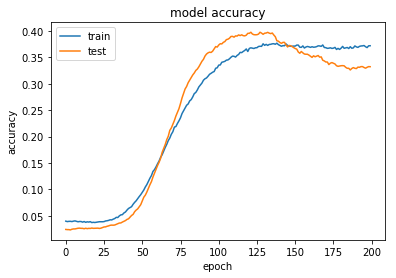

In [100]:
plt.plot(zillow_model.history['acc'])
plt.plot(zillow_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [101]:
model = Sequential()
model.add(Dense(300, input_shape=(130,), activation='relu'))
model.add(Dropout(.05))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(7, activation='softmax'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.00001)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [102]:
business_model = model.fit(x=X_train_business, y=y_cat_train_business, 
          batch_size=2000, 
          epochs=2000, 
          verbose=1, 
          validation_data=(X_test_business, y_cat_test_business),
          callbacks=None,
          class_weight = class_weight)

Train on 4678 samples, validate on 327 samples
Epoch 1/2000
4678/4678 [==============================] - 1s 162us/step - loss: 0.9487 - acc: 0.1511 - val_loss: 1.7497 - val_acc: 0.1376
Epoch 2/2000
4678/4678 [==============================] - 0s 25us/step - loss: 0.9389 - acc: 0.1806 - val_loss: 1.7351 - val_acc: 0.1560
Epoch 3/2000
4678/4678 [==============================] - 0s 30us/step - loss: 0.9331 - acc: 0.1892 - val_loss: 1.7235 - val_acc: 0.1743
Epoch 4/2000
4678/4678 [==============================] - 0s 29us/step - loss: 0.9339 - acc: 0.1813 - val_loss: 1.7132 - val_acc: 0.1927
Epoch 5/2000
4678/4678 [==============================] - 0s 31us/step - loss: 0.9308 - acc: 0.1984 - val_loss: 1.7037 - val_acc: 0.2110
Epoch 6/2000
4678/4678 [==============================] - 0s 31us/step - loss: 0.9257 - acc: 0.2155 - val_loss: 1.6945 - val_acc: 0.2263
Epoch 7/2000
4678/4678 [==============================] - 0s 31us/step - loss: 0.9258 - acc: 0.2193 - val_loss: 1.6861 - val_acc: 

4678/4678 [==============================] - 0s 29us/step - loss: 0.8194 - acc: 0.4023 - val_loss: 1.4001 - val_acc: 0.4006
Epoch 61/2000
4678/4678 [==============================] - 0s 38us/step - loss: 0.8138 - acc: 0.4002 - val_loss: 1.3959 - val_acc: 0.4006
Epoch 62/2000
4678/4678 [==============================] - 0s 37us/step - loss: 0.8167 - acc: 0.4072 - val_loss: 1.3921 - val_acc: 0.3945
Epoch 63/2000
4678/4678 [==============================] - 0s 37us/step - loss: 0.8144 - acc: 0.4000 - val_loss: 1.3882 - val_acc: 0.3976
Epoch 64/2000
4678/4678 [==============================] - 0s 32us/step - loss: 0.8107 - acc: 0.4091 - val_loss: 1.3850 - val_acc: 0.4006
Epoch 65/2000
4678/4678 [==============================] - 0s 34us/step - loss: 0.8110 - acc: 0.4017 - val_loss: 1.3812 - val_acc: 0.3914
Epoch 66/2000
4678/4678 [==============================] - 0s 33us/step - loss: 0.8064 - acc: 0.3933 - val_loss: 1.3778 - val_acc: 0.3914
Epoch 67/2000
4678/4678 [=======================

4678/4678 [==============================] - 0s 32us/step - loss: 0.7577 - acc: 0.3390 - val_loss: 1.2626 - val_acc: 0.2844
Epoch 120/2000
4678/4678 [==============================] - 0s 30us/step - loss: 0.7578 - acc: 0.3311 - val_loss: 1.2609 - val_acc: 0.2844
Epoch 121/2000
4678/4678 [==============================] - 0s 27us/step - loss: 0.7587 - acc: 0.3345 - val_loss: 1.2602 - val_acc: 0.2844
Epoch 122/2000
4678/4678 [==============================] - 0s 33us/step - loss: 0.7589 - acc: 0.3296 - val_loss: 1.2592 - val_acc: 0.2844
Epoch 123/2000
4678/4678 [==============================] - 0s 32us/step - loss: 0.7568 - acc: 0.3298 - val_loss: 1.2582 - val_acc: 0.2844
Epoch 124/2000
4678/4678 [==============================] - 0s 32us/step - loss: 0.7562 - acc: 0.3429 - val_loss: 1.2573 - val_acc: 0.2844
Epoch 125/2000
4678/4678 [==============================] - 0s 32us/step - loss: 0.7528 - acc: 0.3343 - val_loss: 1.2560 - val_acc: 0.2844
Epoch 126/2000
4678/4678 [================

4678/4678 [==============================] - 0s 32us/step - loss: 0.7311 - acc: 0.3305 - val_loss: 1.2200 - val_acc: 0.2875
Epoch 179/2000
4678/4678 [==============================] - 0s 33us/step - loss: 0.7342 - acc: 0.3245 - val_loss: 1.2192 - val_acc: 0.2875
Epoch 180/2000
4678/4678 [==============================] - 0s 30us/step - loss: 0.7404 - acc: 0.3258 - val_loss: 1.2185 - val_acc: 0.2875
Epoch 181/2000
4678/4678 [==============================] - 0s 29us/step - loss: 0.7299 - acc: 0.3268 - val_loss: 1.2182 - val_acc: 0.2875
Epoch 182/2000
4678/4678 [==============================] - 0s 32us/step - loss: 0.7330 - acc: 0.3241 - val_loss: 1.2178 - val_acc: 0.2875
Epoch 183/2000
4678/4678 [==============================] - 0s 30us/step - loss: 0.7353 - acc: 0.3211 - val_loss: 1.2180 - val_acc: 0.2875
Epoch 184/2000
4678/4678 [==============================] - 0s 35us/step - loss: 0.7344 - acc: 0.3219 - val_loss: 1.2165 - val_acc: 0.2875
Epoch 185/2000
4678/4678 [================

4678/4678 [==============================] - 0s 38us/step - loss: 0.7228 - acc: 0.3431 - val_loss: 1.1926 - val_acc: 0.2875
Epoch 238/2000
4678/4678 [==============================] - 0s 32us/step - loss: 0.7256 - acc: 0.3431 - val_loss: 1.1920 - val_acc: 0.2875
Epoch 239/2000
4678/4678 [==============================] - 0s 31us/step - loss: 0.7251 - acc: 0.3474 - val_loss: 1.1917 - val_acc: 0.2875
Epoch 240/2000
4678/4678 [==============================] - 0s 30us/step - loss: 0.7231 - acc: 0.3397 - val_loss: 1.1915 - val_acc: 0.2875
Epoch 241/2000
4678/4678 [==============================] - 0s 33us/step - loss: 0.7266 - acc: 0.3392 - val_loss: 1.1904 - val_acc: 0.2875
Epoch 242/2000
4678/4678 [==============================] - 0s 32us/step - loss: 0.7239 - acc: 0.3348 - val_loss: 1.1908 - val_acc: 0.2875
Epoch 243/2000
4678/4678 [==============================] - 0s 32us/step - loss: 0.7236 - acc: 0.3352 - val_loss: 1.1907 - val_acc: 0.2875
Epoch 244/2000
4678/4678 [================

4678/4678 [==============================] - 0s 31us/step - loss: 0.7185 - acc: 0.3506 - val_loss: 1.1764 - val_acc: 0.2783
Epoch 297/2000
4678/4678 [==============================] - 0s 32us/step - loss: 0.7175 - acc: 0.3457 - val_loss: 1.1763 - val_acc: 0.2783
Epoch 298/2000
4678/4678 [==============================] - 0s 31us/step - loss: 0.7119 - acc: 0.3487 - val_loss: 1.1754 - val_acc: 0.2783
Epoch 299/2000
4678/4678 [==============================] - 0s 30us/step - loss: 0.7195 - acc: 0.3521 - val_loss: 1.1750 - val_acc: 0.2783
Epoch 300/2000
4678/4678 [==============================] - 0s 33us/step - loss: 0.7185 - acc: 0.3382 - val_loss: 1.1755 - val_acc: 0.2813
Epoch 301/2000
4678/4678 [==============================] - 0s 30us/step - loss: 0.7153 - acc: 0.3531 - val_loss: 1.1758 - val_acc: 0.2813
Epoch 302/2000
4678/4678 [==============================] - 0s 33us/step - loss: 0.7183 - acc: 0.3525 - val_loss: 1.1763 - val_acc: 0.2813
Epoch 303/2000
4678/4678 [================

KeyboardInterrupt: 

In [ ]:
plt.plot(business_model.history['acc'])
plt.plot(business_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [681]:
model = Sequential()
model.add(Dense(300, input_shape=(631,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(7, activation='softmax'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.002)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [682]:
w2v_model = model.fit(x=X_train_w2v, y=y_cat_train_w2v, 
          batch_size=2000, 
          epochs=2000, 
          verbose=1, 
          validation_data=(X_test_w2v, y_cat_test_w2v),
          callbacks=None,
          class_weight = class_weight)

Train on 12650 samples, validate on 331 samples
Epoch 1/2000
12650/12650 [==============================] - 2s 190us/step - loss: 0.8484 - acc: 0.3406 - val_loss: 1.4032 - val_acc: 0.2175
Epoch 2/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.7493 - acc: 0.3728 - val_loss: 1.2534 - val_acc: 0.2175
Epoch 3/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.7360 - acc: 0.3949 - val_loss: 1.2392 - val_acc: 0.2175
Epoch 4/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.7227 - acc: 0.3878 - val_loss: 1.4104 - val_acc: 0.2266
Epoch 5/2000
12650/12650 [==============================] - 1s 57us/step - loss: 0.7220 - acc: 0.4017 - val_loss: 1.2455 - val_acc: 0.2236
Epoch 6/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.7083 - acc: 0.3850 - val_loss: 1.2355 - val_acc: 0.2205
Epoch 7/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.7049 - acc: 0.3987 - val_loss: 1.3

12650/12650 [==============================] - 1s 70us/step - loss: 0.5771 - acc: 0.4417 - val_loss: 1.0807 - val_acc: 0.5136
Epoch 60/2000
12650/12650 [==============================] - 1s 68us/step - loss: 0.5852 - acc: 0.4281 - val_loss: 1.1780 - val_acc: 0.4441
Epoch 61/2000
12650/12650 [==============================] - 1s 66us/step - loss: 0.5726 - acc: 0.4638 - val_loss: 1.0126 - val_acc: 0.5650
Epoch 62/2000
12650/12650 [==============================] - 1s 63us/step - loss: 0.5820 - acc: 0.4613 - val_loss: 1.1057 - val_acc: 0.4894
Epoch 63/2000
12650/12650 [==============================] - 1s 69us/step - loss: 0.5712 - acc: 0.4744 - val_loss: 1.2118 - val_acc: 0.3505
Epoch 64/2000
12650/12650 [==============================] - 1s 65us/step - loss: 0.5762 - acc: 0.4140 - val_loss: 1.1618 - val_acc: 0.4713
Epoch 65/2000
12650/12650 [==============================] - 1s 71us/step - loss: 0.5728 - acc: 0.4593 - val_loss: 1.2021 - val_acc: 0.4350
Epoch 66/2000
12650/12650 [=======

12650/12650 [==============================] - 1s 70us/step - loss: 0.5117 - acc: 0.4898 - val_loss: 1.1912 - val_acc: 0.4713
Epoch 118/2000
12650/12650 [==============================] - ETA: 0s - loss: 0.5215 - acc: 0.465 - 1s 67us/step - loss: 0.5224 - acc: 0.4697 - val_loss: 1.1136 - val_acc: 0.5287
Epoch 119/2000
12650/12650 [==============================] - 1s 67us/step - loss: 0.5279 - acc: 0.4788 - val_loss: 1.0684 - val_acc: 0.5408
Epoch 120/2000
12650/12650 [==============================] - 1s 60us/step - loss: 0.5074 - acc: 0.5002 - val_loss: 1.0383 - val_acc: 0.5559
Epoch 121/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.5288 - acc: 0.4759 - val_loss: 1.1393 - val_acc: 0.5166
Epoch 122/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.5135 - acc: 0.5072 - val_loss: 1.2113 - val_acc: 0.4743
Epoch 123/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.5305 - acc: 0.4617 - val_loss: 1.1368 - val_ac

Epoch 175/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.4701 - acc: 0.5096 - val_loss: 1.2813 - val_acc: 0.4894
Epoch 176/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.4850 - acc: 0.4945 - val_loss: 1.2833 - val_acc: 0.5015
Epoch 177/2000
12650/12650 [==============================] - 1s 58us/step - loss: 0.4871 - acc: 0.4975 - val_loss: 1.2268 - val_acc: 0.5378
Epoch 178/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.4876 - acc: 0.4928 - val_loss: 1.3052 - val_acc: 0.4894
Epoch 179/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.4516 - acc: 0.5304 - val_loss: 1.5637 - val_acc: 0.4018
Epoch 180/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.5037 - acc: 0.4771 - val_loss: 1.3993 - val_acc: 0.4743
Epoch 181/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.4599 - acc: 0.5271 - val_loss: 1.3280 - val_acc: 0.5015
Epoch 182/200

12650/12650 [==============================] - 1s 70us/step - loss: 0.4417 - acc: 0.5413 - val_loss: 1.4242 - val_acc: 0.5317
Epoch 234/2000
12650/12650 [==============================] - 1s 66us/step - loss: 0.4200 - acc: 0.5609 - val_loss: 1.2554 - val_acc: 0.5378
Epoch 235/2000
12650/12650 [==============================] - 1s 69us/step - loss: 0.4492 - acc: 0.5274 - val_loss: 1.3685 - val_acc: 0.5287
Epoch 236/2000
12650/12650 [==============================] - 1s 65us/step - loss: 0.4189 - acc: 0.5640 - val_loss: 1.8755 - val_acc: 0.3595
Epoch 237/2000
12650/12650 [==============================] - 1s 63us/step - loss: 0.4485 - acc: 0.5143 - val_loss: 1.4602 - val_acc: 0.4079
Epoch 238/2000
12650/12650 [==============================] - 1s 71us/step - loss: 0.4179 - acc: 0.5156 - val_loss: 1.5527 - val_acc: 0.5106
Epoch 239/2000
12650/12650 [==============================] - 1s 63us/step - loss: 0.4482 - acc: 0.5298 - val_loss: 1.3036 - val_acc: 0.5015
Epoch 240/2000
12650/12650 [

12650/12650 [==============================] - 1s 57us/step - loss: 0.3892 - acc: 0.5667 - val_loss: 2.0843 - val_acc: 0.3686
Epoch 292/2000
12650/12650 [==============================] - 1s 57us/step - loss: 0.4236 - acc: 0.5477 - val_loss: 1.7679 - val_acc: 0.4471
Epoch 293/2000
12650/12650 [==============================] - 1s 58us/step - loss: 0.3925 - acc: 0.5881 - val_loss: 1.6346 - val_acc: 0.3897
Epoch 294/2000
12650/12650 [==============================] - 1s 57us/step - loss: 0.4193 - acc: 0.5250 - val_loss: 1.8329 - val_acc: 0.4230
Epoch 295/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.4058 - acc: 0.5594 - val_loss: 1.5181 - val_acc: 0.4713
Epoch 296/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.4007 - acc: 0.5591 - val_loss: 1.6502 - val_acc: 0.4894
Epoch 297/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.3869 - acc: 0.5851 - val_loss: 1.6197 - val_acc: 0.4532
Epoch 298/2000
12650/12650 [

12650/12650 [==============================] - 1s 67us/step - loss: 0.3742 - acc: 0.5817 - val_loss: 1.9776 - val_acc: 0.4169
Epoch 350/2000
12650/12650 [==============================] - 1s 69us/step - loss: 0.3995 - acc: 0.5639 - val_loss: 1.7450 - val_acc: 0.4713
Epoch 351/2000
12650/12650 [==============================] - 1s 62us/step - loss: 0.3876 - acc: 0.5729 - val_loss: 1.6586 - val_acc: 0.4924
Epoch 352/2000
12650/12650 [==============================] - 1s 70us/step - loss: 0.3818 - acc: 0.5948 - val_loss: 2.0608 - val_acc: 0.3263
Epoch 353/2000
12650/12650 [==============================] - 1s 69us/step - loss: 0.3806 - acc: 0.5561 - val_loss: 2.0006 - val_acc: 0.4713
Epoch 354/2000
12650/12650 [==============================] - 1s 66us/step - loss: 0.4049 - acc: 0.5677 - val_loss: 1.7907 - val_acc: 0.4773
Epoch 355/2000
12650/12650 [==============================] - 1s 68us/step - loss: 0.3617 - acc: 0.6068 - val_loss: 1.9441 - val_acc: 0.4804
Epoch 356/2000
12650/12650 [

12650/12650 [==============================] - 1s 57us/step - loss: 0.3828 - acc: 0.5803 - val_loss: 1.9643 - val_acc: 0.4562
Epoch 408/2000
12650/12650 [==============================] - 1s 65us/step - loss: 0.3572 - acc: 0.6015 - val_loss: 1.8360 - val_acc: 0.4955
Epoch 409/2000
12650/12650 [==============================] - 1s 69us/step - loss: 0.3860 - acc: 0.5730 - val_loss: 1.7403 - val_acc: 0.5076
Epoch 410/2000
12650/12650 [==============================] - 1s 63us/step - loss: 0.3513 - acc: 0.6094 - val_loss: 1.9717 - val_acc: 0.4683
Epoch 411/2000
12650/12650 [==============================] - 1s 63us/step - loss: 0.3745 - acc: 0.5926 - val_loss: 1.8499 - val_acc: 0.5136
Epoch 412/2000
12650/12650 [==============================] - 1s 70us/step - loss: 0.3940 - acc: 0.5740 - val_loss: 1.7817 - val_acc: 0.4985
Epoch 413/2000
12650/12650 [==============================] - 1s 73us/step - loss: 0.3410 - acc: 0.6209 - val_loss: 1.9681 - val_acc: 0.4773
Epoch 414/2000
12650/12650 [

12650/12650 [==============================] - 1s 57us/step - loss: 0.3509 - acc: 0.6218 - val_loss: 1.8660 - val_acc: 0.4743
Epoch 466/2000
12650/12650 [==============================] - 1s 69us/step - loss: 0.3382 - acc: 0.6219 - val_loss: 2.0156 - val_acc: 0.4653
Epoch 467/2000
12650/12650 [==============================] - 1s 67us/step - loss: 0.3347 - acc: 0.6361 - val_loss: 2.4513 - val_acc: 0.4199
Epoch 468/2000
12650/12650 [==============================] - 1s 70us/step - loss: 0.3802 - acc: 0.5855 - val_loss: 2.0989 - val_acc: 0.4924
Epoch 469/2000
12650/12650 [==============================] - 1s 63us/step - loss: 0.3448 - acc: 0.6198 - val_loss: 2.3189 - val_acc: 0.4350
Epoch 470/2000
12650/12650 [==============================] - 1s 58us/step - loss: 0.3344 - acc: 0.6282 - val_loss: 2.6111 - val_acc: 0.3958
Epoch 471/2000
12650/12650 [==============================] - 1s 57us/step - loss: 0.3870 - acc: 0.5948 - val_loss: 1.9755 - val_acc: 0.4743
Epoch 472/2000
12650/12650 [

Epoch 523/2000
12650/12650 [==============================] - 1s 58us/step - loss: 0.3148 - acc: 0.6547 - val_loss: 2.5072 - val_acc: 0.4320
Epoch 524/2000
12650/12650 [==============================] - 1s 72us/step - loss: 0.3493 - acc: 0.6065 - val_loss: 2.4341 - val_acc: 0.4562
Epoch 525/2000
12650/12650 [==============================] - 1s 66us/step - loss: 0.3354 - acc: 0.6312 - val_loss: 2.2696 - val_acc: 0.4411
Epoch 526/2000
12650/12650 [==============================] - 1s 64us/step - loss: 0.3458 - acc: 0.6160 - val_loss: 2.1426 - val_acc: 0.5015
Epoch 527/2000
12650/12650 [==============================] - 1s 65us/step - loss: 0.3297 - acc: 0.6391 - val_loss: 2.0563 - val_acc: 0.4804
Epoch 528/2000
12650/12650 [==============================] - 1s 68us/step - loss: 0.3772 - acc: 0.6028 - val_loss: 1.9315 - val_acc: 0.4773
Epoch 529/2000
12650/12650 [==============================] - 1s 70us/step - loss: 0.3231 - acc: 0.6390 - val_loss: 2.2686 - val_acc: 0.4683
Epoch 530/200

12650/12650 [==============================] - 1s 56us/step - loss: 0.3239 - acc: 0.6461 - val_loss: 1.9561 - val_acc: 0.5317
Epoch 582/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.3264 - acc: 0.6455 - val_loss: 2.3103 - val_acc: 0.4683
Epoch 583/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.3423 - acc: 0.6255 - val_loss: 2.0085 - val_acc: 0.4894
Epoch 584/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.3128 - acc: 0.6526 - val_loss: 2.2603 - val_acc: 0.4743
Epoch 585/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.3184 - acc: 0.6525 - val_loss: 2.1313 - val_acc: 0.4773
Epoch 586/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.3474 - acc: 0.6208 - val_loss: 2.2593 - val_acc: 0.4532
Epoch 587/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.3097 - acc: 0.6531 - val_loss: 2.1170 - val_acc: 0.4471
Epoch 588/2000
12650/12650 [

12650/12650 [==============================] - 1s 69us/step - loss: 0.3193 - acc: 0.6461 - val_loss: 2.5025 - val_acc: 0.4713
Epoch 640/2000
12650/12650 [==============================] - 1s 69us/step - loss: 0.2988 - acc: 0.6599 - val_loss: 2.6100 - val_acc: 0.4562
Epoch 641/2000
12650/12650 [==============================] - 1s 65us/step - loss: 0.3341 - acc: 0.6425 - val_loss: 2.2476 - val_acc: 0.4743
Epoch 642/2000
12650/12650 [==============================] - 1s 71us/step - loss: 0.3053 - acc: 0.6606 - val_loss: 2.5815 - val_acc: 0.4048
Epoch 643/2000
12650/12650 [==============================] - 1s 60us/step - loss: 0.2974 - acc: 0.6630 - val_loss: 2.6995 - val_acc: 0.4230
Epoch 644/2000
12650/12650 [==============================] - 1s 71us/step - loss: 0.3357 - acc: 0.6376 - val_loss: 2.1065 - val_acc: 0.4985
Epoch 645/2000
12650/12650 [==============================] - 1s 61us/step - loss: 0.3001 - acc: 0.6579 - val_loss: 2.4113 - val_acc: 0.4532
Epoch 646/2000
12650/12650 [

12650/12650 [==============================] - 1s 56us/step - loss: 0.2955 - acc: 0.6792 - val_loss: 2.4674 - val_acc: 0.4653
Epoch 698/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.3159 - acc: 0.6475 - val_loss: 2.2474 - val_acc: 0.4562
Epoch 699/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.2828 - acc: 0.6738 - val_loss: 2.4502 - val_acc: 0.4834
Epoch 700/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.3537 - acc: 0.6309 - val_loss: 2.2130 - val_acc: 0.4713
Epoch 701/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.2794 - acc: 0.6806 - val_loss: 2.2989 - val_acc: 0.4864
Epoch 702/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.3091 - acc: 0.6580 - val_loss: 2.2028 - val_acc: 0.4985
Epoch 703/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.2768 - acc: 0.6975 - val_loss: 2.4973 - val_acc: 0.4804
Epoch 704/2000
12650/12650 [

12650/12650 [==============================] - 1s 66us/step - loss: 0.3201 - acc: 0.6538 - val_loss: 2.0957 - val_acc: 0.5015
Epoch 756/2000
12650/12650 [==============================] - 1s 59us/step - loss: 0.2898 - acc: 0.6701 - val_loss: 2.4086 - val_acc: 0.4713
Epoch 757/2000
12650/12650 [==============================] - 1s 69us/step - loss: 0.2817 - acc: 0.6903 - val_loss: 2.4957 - val_acc: 0.4502
Epoch 758/2000
12650/12650 [==============================] - 1s 62us/step - loss: 0.3052 - acc: 0.6630 - val_loss: 2.3969 - val_acc: 0.4622
Epoch 759/2000
12650/12650 [==============================] - 1s 63us/step - loss: 0.2894 - acc: 0.6857 - val_loss: 2.8736 - val_acc: 0.4381
Epoch 760/2000
12650/12650 [==============================] - 1s 62us/step - loss: 0.3002 - acc: 0.6693 - val_loss: 2.0570 - val_acc: 0.5045
Epoch 761/2000
12650/12650 [==============================] - 1s 64us/step - loss: 0.2843 - acc: 0.6748 - val_loss: 2.3371 - val_acc: 0.4864
Epoch 762/2000
12650/12650 [

12650/12650 [==============================] - 1s 67us/step - loss: 0.2891 - acc: 0.6796 - val_loss: 2.3246 - val_acc: 0.4713
Epoch 814/2000
12650/12650 [==============================] - 1s 62us/step - loss: 0.2650 - acc: 0.7037 - val_loss: 2.5580 - val_acc: 0.4864
Epoch 815/2000
12650/12650 [==============================] - 1s 65us/step - loss: 0.3088 - acc: 0.6594 - val_loss: 2.6682 - val_acc: 0.4169
Epoch 816/2000
12650/12650 [==============================] - 1s 66us/step - loss: 0.2722 - acc: 0.6983 - val_loss: 2.9654 - val_acc: 0.4199
Epoch 817/2000
12650/12650 [==============================] - 1s 67us/step - loss: 0.3139 - acc: 0.6557 - val_loss: 2.3354 - val_acc: 0.4834
Epoch 818/2000
12650/12650 [==============================] - 1s 68us/step - loss: 0.2803 - acc: 0.6842 - val_loss: 2.5440 - val_acc: 0.4713
Epoch 819/2000
12650/12650 [==============================] - 1s 67us/step - loss: 0.2862 - acc: 0.6837 - val_loss: 2.4326 - val_acc: 0.4924
Epoch 820/2000
12650/12650 [

12650/12650 [==============================] - 1s 56us/step - loss: 0.2713 - acc: 0.6991 - val_loss: 2.8637 - val_acc: 0.4290
Epoch 872/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.2952 - acc: 0.6711 - val_loss: 2.6558 - val_acc: 0.4441
Epoch 873/2000
12650/12650 [==============================] - 1s 69us/step - loss: 0.2729 - acc: 0.7005 - val_loss: 2.4084 - val_acc: 0.4773
Epoch 874/2000
12650/12650 [==============================] - 1s 65us/step - loss: 0.2920 - acc: 0.6785 - val_loss: 2.5494 - val_acc: 0.4622
Epoch 875/2000
12650/12650 [==============================] - 1s 64us/step - loss: 0.2623 - acc: 0.7091 - val_loss: 2.6543 - val_acc: 0.4441
Epoch 876/2000
12650/12650 [==============================] - 1s 58us/step - loss: 0.2817 - acc: 0.6901 - val_loss: 2.4468 - val_acc: 0.4864
Epoch 877/2000
12650/12650 [==============================] - 1s 61us/step - loss: 0.2754 - acc: 0.6954 - val_loss: 2.7241 - val_acc: 0.4230
Epoch 878/2000
12650/12650 [

12650/12650 [==============================] - 1s 56us/step - loss: 0.2706 - acc: 0.7030 - val_loss: 2.5602 - val_acc: 0.4532
Epoch 930/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.2497 - acc: 0.7205 - val_loss: 2.9286 - val_acc: 0.4864
Epoch 931/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.2906 - acc: 0.6723 - val_loss: 2.4044 - val_acc: 0.4622
Epoch 932/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.2712 - acc: 0.7004 - val_loss: 2.5436 - val_acc: 0.4622
Epoch 933/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.2655 - acc: 0.6987 - val_loss: 2.7843 - val_acc: 0.4622
Epoch 934/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.2667 - acc: 0.7032 - val_loss: 2.6822 - val_acc: 0.4532
Epoch 935/2000
12650/12650 [==============================] - 1s 57us/step - loss: 0.2684 - acc: 0.6949 - val_loss: 2.2937 - val_acc: 0.4924
Epoch 936/2000
12650/12650 [

12650/12650 [==============================] - 1s 59us/step - loss: 0.2632 - acc: 0.7225 - val_loss: 2.6846 - val_acc: 0.4773
Epoch 988/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.2607 - acc: 0.7145 - val_loss: 2.2541 - val_acc: 0.5347
Epoch 989/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.2634 - acc: 0.7069 - val_loss: 2.6021 - val_acc: 0.5045
Epoch 990/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.2626 - acc: 0.7143 - val_loss: 2.9088 - val_acc: 0.4350
Epoch 991/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.2640 - acc: 0.7091 - val_loss: 2.6921 - val_acc: 0.4713
Epoch 992/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.2589 - acc: 0.7093 - val_loss: 2.7337 - val_acc: 0.5076
Epoch 993/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.2833 - acc: 0.6923 - val_loss: 2.8021 - val_acc: 0.4592
Epoch 994/2000
12650/12650 [

Epoch 1045/2000
12650/12650 [==============================] - 1s 62us/step - loss: 0.2464 - acc: 0.7234 - val_loss: 2.6268 - val_acc: 0.4653
Epoch 1046/2000
12650/12650 [==============================] - 1s 69us/step - loss: 0.2754 - acc: 0.7009 - val_loss: 2.7208 - val_acc: 0.4532
Epoch 1047/2000
12650/12650 [==============================] - 1s 67us/step - loss: 0.2504 - acc: 0.7221 - val_loss: 2.6603 - val_acc: 0.4864
Epoch 1048/2000
12650/12650 [==============================] - 1s 66us/step - loss: 0.2563 - acc: 0.7323 - val_loss: 3.2400 - val_acc: 0.4441
Epoch 1049/2000
12650/12650 [==============================] - 1s 71us/step - loss: 0.2634 - acc: 0.7062 - val_loss: 2.8110 - val_acc: 0.4320
Epoch 1050/2000
12650/12650 [==============================] - 1s 64us/step - loss: 0.2603 - acc: 0.7019 - val_loss: 2.5114 - val_acc: 0.4773
Epoch 1051/2000
12650/12650 [==============================] - 1s 71us/step - loss: 0.2741 - acc: 0.7085 - val_loss: 2.9478 - val_acc: 0.4320
Epoch 

12650/12650 [==============================] - 1s 57us/step - loss: 0.2653 - acc: 0.7005 - val_loss: 2.7500 - val_acc: 0.4773
Epoch 1103/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.2408 - acc: 0.7398 - val_loss: 2.8638 - val_acc: 0.4199
Epoch 1104/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.2773 - acc: 0.7006 - val_loss: 2.7592 - val_acc: 0.4350
Epoch 1105/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.2471 - acc: 0.7218 - val_loss: 2.2721 - val_acc: 0.5347
Epoch 1106/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.2549 - acc: 0.7180 - val_loss: 2.9189 - val_acc: 0.4653
Epoch 1107/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.2497 - acc: 0.7187 - val_loss: 2.6389 - val_acc: 0.4713
Epoch 1108/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.2439 - acc: 0.7301 - val_loss: 2.7597 - val_acc: 0.4804
Epoch 1109/2000
12650/

Epoch 1160/2000
12650/12650 [==============================] - 1s 59us/step - loss: 0.2468 - acc: 0.7260 - val_loss: 2.8367 - val_acc: 0.4713
Epoch 1161/2000
12650/12650 [==============================] - 1s 63us/step - loss: 0.2644 - acc: 0.7173 - val_loss: 2.4320 - val_acc: 0.4773
Epoch 1162/2000
12650/12650 [==============================] - 1s 62us/step - loss: 0.2334 - acc: 0.7398 - val_loss: 3.0983 - val_acc: 0.3988
Epoch 1163/2000
12650/12650 [==============================] - 1s 63us/step - loss: 0.2677 - acc: 0.7009 - val_loss: 2.7535 - val_acc: 0.4471
Epoch 1164/2000
12650/12650 [==============================] - 1s 61us/step - loss: 0.2382 - acc: 0.7368 - val_loss: 2.5544 - val_acc: 0.5076
Epoch 1165/2000
12650/12650 [==============================] - 1s 57us/step - loss: 0.2425 - acc: 0.7383 - val_loss: 2.7667 - val_acc: 0.4804
Epoch 1166/2000
12650/12650 [==============================] - 1s 61us/step - loss: 0.2613 - acc: 0.7149 - val_loss: 2.7616 - val_acc: 0.4230
Epoch 

12650/12650 [==============================] - 1s 64us/step - loss: 0.2356 - acc: 0.7337 - val_loss: 2.6419 - val_acc: 0.4924
Epoch 1218/2000
12650/12650 [==============================] - 1s 65us/step - loss: 0.2500 - acc: 0.7240 - val_loss: 2.8258 - val_acc: 0.4139
Epoch 1219/2000
12650/12650 [==============================] - 1s 59us/step - loss: 0.2370 - acc: 0.7373 - val_loss: 2.6029 - val_acc: 0.4864
Epoch 1220/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.2455 - acc: 0.7258 - val_loss: 2.8343 - val_acc: 0.4562
Epoch 1221/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.2539 - acc: 0.7279 - val_loss: 2.4110 - val_acc: 0.4834
Epoch 1222/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.2397 - acc: 0.7247 - val_loss: 2.8177 - val_acc: 0.4955
Epoch 1223/2000
12650/12650 [==============================] - 1s 67us/step - loss: 0.2241 - acc: 0.7636 - val_loss: 2.9922 - val_acc: 0.4653
Epoch 1224/2000
12650/

Epoch 1275/2000
12650/12650 [==============================] - 1s 62us/step - loss: 0.2365 - acc: 0.7409 - val_loss: 3.0642 - val_acc: 0.4562
Epoch 1276/2000
12650/12650 [==============================] - 1s 70us/step - loss: 0.2439 - acc: 0.7381 - val_loss: 2.6931 - val_acc: 0.4804
Epoch 1277/2000
12650/12650 [==============================] - 1s 70us/step - loss: 0.2487 - acc: 0.7170 - val_loss: 2.9068 - val_acc: 0.4441
Epoch 1278/2000
12650/12650 [==============================] - 1s 70us/step - loss: 0.2305 - acc: 0.7440 - val_loss: 2.6697 - val_acc: 0.5076
Epoch 1279/2000
12650/12650 [==============================] - 1s 67us/step - loss: 0.2425 - acc: 0.7340 - val_loss: 2.7718 - val_acc: 0.4079
Epoch 1280/2000
12650/12650 [==============================] - 1s 59us/step - loss: 0.2545 - acc: 0.7193 - val_loss: 2.7434 - val_acc: 0.4743
Epoch 1281/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.2327 - acc: 0.7407 - val_loss: 2.6020 - val_acc: 0.5045
Epoch 

12650/12650 [==============================] - 1s 69us/step - loss: 0.2349 - acc: 0.7496 - val_loss: 2.7719 - val_acc: 0.4562
Epoch 1333/2000
12650/12650 [==============================] - 1s 70us/step - loss: 0.2150 - acc: 0.7643 - val_loss: 2.8887 - val_acc: 0.4290
Epoch 1334/2000
12650/12650 [==============================] - 1s 71us/step - loss: 0.2326 - acc: 0.7476 - val_loss: 3.2779 - val_acc: 0.4139
Epoch 1335/2000
12650/12650 [==============================] - 1s 70us/step - loss: 0.2572 - acc: 0.7330 - val_loss: 2.3367 - val_acc: 0.4894
Epoch 1336/2000
12650/12650 [==============================] - 1s 66us/step - loss: 0.2326 - acc: 0.7536 - val_loss: 2.6772 - val_acc: 0.4985
Epoch 1337/2000
12650/12650 [==============================] - 1s 70us/step - loss: 0.2516 - acc: 0.7255 - val_loss: 2.4290 - val_acc: 0.4592
Epoch 1338/2000
12650/12650 [==============================] - 1s 76us/step - loss: 0.2449 - acc: 0.7360 - val_loss: 2.7173 - val_acc: 0.5015
Epoch 1339/2000
12650/

12650/12650 [==============================] - 1s 66us/step - loss: 0.2388 - acc: 0.7414 - val_loss: 2.6394 - val_acc: 0.4502
Epoch 1390/2000
12650/12650 [==============================] - 1s 66us/step - loss: 0.2230 - acc: 0.7455 - val_loss: 3.0640 - val_acc: 0.4532
Epoch 1391/2000
12650/12650 [==============================] - 1s 68us/step - loss: 0.2317 - acc: 0.7451 - val_loss: 2.6937 - val_acc: 0.4713
Epoch 1392/2000
12650/12650 [==============================] - 1s 62us/step - loss: 0.2422 - acc: 0.7473 - val_loss: 2.7373 - val_acc: 0.4562
Epoch 1393/2000
12650/12650 [==============================] - 1s 66us/step - loss: 0.2433 - acc: 0.7294 - val_loss: 2.5438 - val_acc: 0.4804
Epoch 1394/2000
12650/12650 [==============================] - 1s 61us/step - loss: 0.2361 - acc: 0.7449 - val_loss: 2.9538 - val_acc: 0.4653
Epoch 1395/2000
12650/12650 [==============================] - 1s 62us/step - loss: 0.2326 - acc: 0.7432 - val_loss: 2.6024 - val_acc: 0.4773
Epoch 1396/2000
12650/

Epoch 1447/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.2271 - acc: 0.7520 - val_loss: 3.1854 - val_acc: 0.4199
Epoch 1448/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.2574 - acc: 0.7308 - val_loss: 2.5010 - val_acc: 0.4894
Epoch 1449/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.2428 - acc: 0.7481 - val_loss: 2.5289 - val_acc: 0.4653
Epoch 1450/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.2234 - acc: 0.7627 - val_loss: 2.6817 - val_acc: 0.4562
Epoch 1451/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.2281 - acc: 0.7485 - val_loss: 2.7299 - val_acc: 0.5076
Epoch 1452/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.2388 - acc: 0.7495 - val_loss: 2.4992 - val_acc: 0.4985
Epoch 1453/2000
12650/12650 [==============================] - 1s 59us/step - loss: 0.2246 - acc: 0.7559 - val_loss: 2.7543 - val_acc: 0.4924
Epoch 

12650/12650 [==============================] - 1s 56us/step - loss: 0.2169 - acc: 0.7628 - val_loss: 2.6964 - val_acc: 0.4834
Epoch 1505/2000
12650/12650 [==============================] - 1s 60us/step - loss: 0.2335 - acc: 0.7343 - val_loss: 2.8949 - val_acc: 0.5045
Epoch 1506/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.2139 - acc: 0.7641 - val_loss: 2.7183 - val_acc: 0.4683
Epoch 1507/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.2433 - acc: 0.7413 - val_loss: 2.7209 - val_acc: 0.4985
Epoch 1508/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.2288 - acc: 0.7560 - val_loss: 2.6442 - val_acc: 0.5227
Epoch 1509/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.2255 - acc: 0.7529 - val_loss: 2.9531 - val_acc: 0.4592
Epoch 1510/2000
12650/12650 [==============================] - 1s 55us/step - loss: 0.2178 - acc: 0.7660 - val_loss: 3.0103 - val_acc: 0.4743
Epoch 1511/2000
12650/

Epoch 1562/2000
12650/12650 [==============================] - ETA: 0s - loss: 0.2370 - acc: 0.745 - 1s 60us/step - loss: 0.2343 - acc: 0.7459 - val_loss: 2.9937 - val_acc: 0.4864
Epoch 1563/2000
12650/12650 [==============================] - 1s 67us/step - loss: 0.2317 - acc: 0.7478 - val_loss: 2.7206 - val_acc: 0.4683
Epoch 1564/2000
12650/12650 [==============================] - 1s 58us/step - loss: 0.2126 - acc: 0.7844 - val_loss: 2.9388 - val_acc: 0.4592
Epoch 1565/2000
12650/12650 [==============================] - 1s 68us/step - loss: 0.2192 - acc: 0.7670 - val_loss: 3.1383 - val_acc: 0.4532
Epoch 1566/2000
12650/12650 [==============================] - 1s 59us/step - loss: 0.2167 - acc: 0.7705 - val_loss: 3.2191 - val_acc: 0.4290
Epoch 1567/2000
12650/12650 [==============================] - 1s 57us/step - loss: 0.2097 - acc: 0.7711 - val_loss: 3.3580 - val_acc: 0.4562
Epoch 1568/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.2471 - acc: 0.7364 - val

12650/12650 [==============================] - 1s 69us/step - loss: 0.2123 - acc: 0.7695 - val_loss: 3.2817 - val_acc: 0.4441
Epoch 1620/2000
12650/12650 [==============================] - 1s 67us/step - loss: 0.2195 - acc: 0.7565 - val_loss: 2.5574 - val_acc: 0.5015
Epoch 1621/2000
12650/12650 [==============================] - 1s 62us/step - loss: 0.2409 - acc: 0.7463 - val_loss: 3.1717 - val_acc: 0.4290
Epoch 1622/2000
12650/12650 [==============================] - 1s 62us/step - loss: 0.2331 - acc: 0.7582 - val_loss: 2.8845 - val_acc: 0.4471
Epoch 1623/2000
12650/12650 [==============================] - 1s 61us/step - loss: 0.2126 - acc: 0.7738 - val_loss: 2.9585 - val_acc: 0.4985
Epoch 1624/2000
12650/12650 [==============================] - 1s 65us/step - loss: 0.2205 - acc: 0.7693 - val_loss: 2.5824 - val_acc: 0.5076
Epoch 1625/2000
12650/12650 [==============================] - 1s 63us/step - loss: 0.2244 - acc: 0.7628 - val_loss: 2.8450 - val_acc: 0.4653
Epoch 1626/2000
12650/

Epoch 1677/2000
12650/12650 [==============================] - 1s 67us/step - loss: 0.2107 - acc: 0.7719 - val_loss: 3.1547 - val_acc: 0.4502
Epoch 1678/2000
12650/12650 [==============================] - 1s 61us/step - loss: 0.2181 - acc: 0.7692 - val_loss: 2.7471 - val_acc: 0.4441
Epoch 1679/2000
12650/12650 [==============================] - 1s 57us/step - loss: 0.2153 - acc: 0.7590 - val_loss: 2.9554 - val_acc: 0.4683
Epoch 1680/2000
12650/12650 [==============================] - 1s 57us/step - loss: 0.2097 - acc: 0.7748 - val_loss: 2.7642 - val_acc: 0.4713
Epoch 1681/2000
12650/12650 [==============================] - 1s 66us/step - loss: 0.2087 - acc: 0.7764 - val_loss: 3.1450 - val_acc: 0.4834
Epoch 1682/2000
12650/12650 [==============================] - 1s 63us/step - loss: 0.2190 - acc: 0.7684 - val_loss: 2.9785 - val_acc: 0.4562
Epoch 1683/2000
12650/12650 [==============================] - 1s 64us/step - loss: 0.2295 - acc: 0.7500 - val_loss: 3.3311 - val_acc: 0.4441
Epoch 

12650/12650 [==============================] - 1s 61us/step - loss: 0.2314 - acc: 0.7631 - val_loss: 3.0176 - val_acc: 0.4743
Epoch 1735/2000
12650/12650 [==============================] - 1s 66us/step - loss: 0.2093 - acc: 0.7744 - val_loss: 2.9012 - val_acc: 0.4653
Epoch 1736/2000
12650/12650 [==============================] - 1s 61us/step - loss: 0.2206 - acc: 0.7685 - val_loss: 3.1639 - val_acc: 0.4713
Epoch 1737/2000
12650/12650 [==============================] - 1s 56us/step - loss: 0.2042 - acc: 0.7829 - val_loss: 3.0393 - val_acc: 0.4562
Epoch 1738/2000
12650/12650 [==============================] - 1s 59us/step - loss: 0.2224 - acc: 0.7655 - val_loss: 2.9998 - val_acc: 0.4622
Epoch 1739/2000
12650/12650 [==============================] - 1s 66us/step - loss: 0.2041 - acc: 0.7843 - val_loss: 3.0657 - val_acc: 0.4683
Epoch 1740/2000
12650/12650 [==============================] - 1s 60us/step - loss: 0.2129 - acc: 0.7785 - val_loss: 3.3546 - val_acc: 0.4653
Epoch 1741/2000
12650/

Epoch 1792/2000
12650/12650 [==============================] - 1s 62us/step - loss: 0.2080 - acc: 0.7719 - val_loss: 2.9792 - val_acc: 0.4562
Epoch 1793/2000
12650/12650 [==============================] - 1s 62us/step - loss: 0.2062 - acc: 0.7739 - val_loss: 3.2996 - val_acc: 0.4471
Epoch 1794/2000
12650/12650 [==============================] - 1s 58us/step - loss: 0.2021 - acc: 0.7741 - val_loss: 2.8691 - val_acc: 0.4773
Epoch 1795/2000
12650/12650 [==============================] - 1s 64us/step - loss: 0.2373 - acc: 0.7481 - val_loss: 2.8924 - val_acc: 0.4320
Epoch 1796/2000
12650/12650 [==============================] - 1s 62us/step - loss: 0.2037 - acc: 0.7746 - val_loss: 2.8042 - val_acc: 0.5015
Epoch 1797/2000
12650/12650 [==============================] - 1s 57us/step - loss: 0.2147 - acc: 0.7760 - val_loss: 2.8343 - val_acc: 0.4834
Epoch 1798/2000
12650/12650 [==============================] - 1s 58us/step - loss: 0.1968 - acc: 0.7943 - val_loss: 3.0594 - val_acc: 0.4743
Epoch 

12650/12650 [==============================] - 1s 64us/step - loss: 0.2008 - acc: 0.7846 - val_loss: 3.1355 - val_acc: 0.4713
Epoch 1850/2000
12650/12650 [==============================] - 1s 64us/step - loss: 0.2128 - acc: 0.7745 - val_loss: 3.4544 - val_acc: 0.4441
Epoch 1851/2000
12650/12650 [==============================] - 1s 62us/step - loss: 0.2094 - acc: 0.7681 - val_loss: 2.9192 - val_acc: 0.4864
Epoch 1852/2000
12650/12650 [==============================] - 1s 63us/step - loss: 0.1955 - acc: 0.7958 - val_loss: 3.8035 - val_acc: 0.4230
Epoch 1853/2000
12650/12650 [==============================] - 1s 62us/step - loss: 0.2066 - acc: 0.7870 - val_loss: 3.5137 - val_acc: 0.4230
Epoch 1854/2000
12650/12650 [==============================] - 1s 62us/step - loss: 0.2203 - acc: 0.7519 - val_loss: 2.8264 - val_acc: 0.4864
Epoch 1855/2000
12650/12650 [==============================] - 1s 67us/step - loss: 0.1983 - acc: 0.7817 - val_loss: 3.2129 - val_acc: 0.4290
Epoch 1856/2000
12650/

Epoch 1907/2000
12650/12650 [==============================] - 1s 61us/step - loss: 0.2192 - acc: 0.7674 - val_loss: 3.1261 - val_acc: 0.4411
Epoch 1908/2000
12650/12650 [==============================] - 1s 61us/step - loss: 0.2033 - acc: 0.7862 - val_loss: 2.9431 - val_acc: 0.4532
Epoch 1909/2000
12650/12650 [==============================] - 1s 64us/step - loss: 0.2068 - acc: 0.7802 - val_loss: 2.7827 - val_acc: 0.5136
Epoch 1910/2000
12650/12650 [==============================] - 1s 68us/step - loss: 0.2001 - acc: 0.7843 - val_loss: 3.0434 - val_acc: 0.4955
Epoch 1911/2000
12650/12650 [==============================] - 1s 63us/step - loss: 0.2026 - acc: 0.7911 - val_loss: 2.9694 - val_acc: 0.4683
Epoch 1912/2000
12650/12650 [==============================] - 1s 63us/step - loss: 0.1997 - acc: 0.7824 - val_loss: 2.8885 - val_acc: 0.4924
Epoch 1913/2000
12650/12650 [==============================] - 1s 63us/step - loss: 0.2184 - acc: 0.7759 - val_loss: 3.2558 - val_acc: 0.4743
Epoch 

12650/12650 [==============================] - 1s 68us/step - loss: 0.1999 - acc: 0.7840 - val_loss: 3.1717 - val_acc: 0.4471
Epoch 1965/2000
12650/12650 [==============================] - 1s 63us/step - loss: 0.2077 - acc: 0.7746 - val_loss: 2.8460 - val_acc: 0.5015
Epoch 1966/2000
12650/12650 [==============================] - 1s 60us/step - loss: 0.2042 - acc: 0.7829 - val_loss: 2.6097 - val_acc: 0.4653
Epoch 1967/2000
12650/12650 [==============================] - 1s 67us/step - loss: 0.2100 - acc: 0.7704 - val_loss: 2.8669 - val_acc: 0.5045
Epoch 1968/2000
12650/12650 [==============================] - 1s 70us/step - loss: 0.2048 - acc: 0.7861 - val_loss: 2.6700 - val_acc: 0.4834
Epoch 1969/2000
12650/12650 [==============================] - 1s 67us/step - loss: 0.2099 - acc: 0.7655 - val_loss: 2.9424 - val_acc: 0.5136
Epoch 1970/2000
12650/12650 [==============================] - 1s 64us/step - loss: 0.1915 - acc: 0.7990 - val_loss: 2.9157 - val_acc: 0.5166
Epoch 1971/2000
12650/

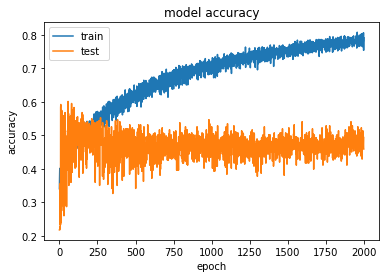

In [683]:
plt.plot(w2v_model.history['acc'])
plt.plot(w2v_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [684]:
t = model.predict(X_test_w2v)

In [685]:
t[14]

array([  0.00000000e+00,   0.00000000e+00,   8.50745710e-06,
         8.21653724e-01,   1.78337783e-01,   2.08113044e-16,
         0.00000000e+00], dtype=float32)

In [686]:
df = pd.DataFrame(t)

In [688]:
df.head(50)

,0,1,2,3,4,5,6
0,0.000000e+00,9.648371e-37,2.260338e-05,7.444282e-01,2.555493e-01,9.191589e-15,0.000000e+00
1,0.000000e+00,0.000000e+00,3.030331e-09,8.122746e-01,1.877254e-01,1.132003e-22,0.000000e+00
2,0.000000e+00,0.000000e+00,2.998153e-10,9.999869e-01,1.308964e-05,0.000000e+00,0.000000e+00
3,7.441208e-32,2.486081e-33,4.855340e-07,3.407179e-02,8.744342e-01,9.149349e-02,1.077171e-09
4,0.000000e+00,6.979696e-36,1.000000e+00,1.965786e-14,0.000000e+00,0.000000e+00,0.000000e+00
5,0.000000e+00,3.337748e-33,6.979010e-01,3.020990e-01,1.909480e-09,0.000000e+00,0.000000e+00
6,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.746127e-18,1.000000e+00,0.000000e+00
7,1.288003e-15,3.188445e-09,7.721534e-02,4.568078e-01,4.655826e-01,3.942615e-04,2.835243e-10
8,0.000000e+00,7.706805e-10,9.988242e-01,1.175860e-03,5.080806e-18,0.000000e+00,0.000000e+00
9,0.000000e+00,0.000000e+00,5.713718e-08,9.999980e-01,2.078858e-06,0.000000e+00,0.000000e+00


In [689]:
y_cat_test_w2v.head(50)

,1,2,3,4,5,6,7
0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0
5,0,0,0,1,0,0,0
6,0,0,0,0,1,0,0
7,0,0,1,0,0,0,0
8,0,0,0,1,0,0,0
9,0,0,0,1,0,0,0


In [690]:
y_cat_test_w2v['7'].sum()

0

In [691]:
y_cat_test_w2v['7'].sum() / len(y_cat_test_w2v)

0.0

In [692]:
y_cat_test_w2v['6'].sum()

10

In [693]:
y_cat_test_w2v['6'].sum() / len(y_cat_test_w2v)

0.030211480362537766

In [694]:
y_cat_test_w2v['5'].sum()

73

In [695]:
y_cat_test_w2v['5'].sum() / len(y_cat_test_w2v)

0.22054380664652568

In [696]:
y_cat_test_w2v['4'].sum()

191

In [697]:
y_cat_test_w2v['4'].sum() / len(y_cat_test_w2v)

0.5770392749244713

In [698]:
y_cat_test_w2v['3'].sum() / len(y_cat_test_w2v)

0.15709969788519637

In [699]:
y_cat_test_w2v['2'].sum()

5

In [700]:
y_cat_test_w2v['2'].sum() / len(y_cat_test_w2v)

0.015105740181268883

In [701]:
y_cat_test_w2v['1'].sum()

0

In [702]:
y_cat_test_w2v['1'].sum() / len(y_cat_test_w2v)

0.0